Hunter Bennett  
Glass Lab  
Created 180205 | Last updated 180628  
____________  
here we are seeking to understand if there are noticeable molecular phenotype within 4 weeks on the NASH diet.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Image
import subprocess
import os
import sys
import glob
import re

# import user defined packages
sys.path.insert(0, '/home/h1bennet/scripts')
import hbUtils

# plot matplotlib plots in notebook
%matplotlib inline

# load extension for running R from python
#  %load_ext rpy2.ipython

sns.set(font_scale=1)
sns.set_context('talk')
sns.set_style('white')

Make output directory

In [2]:
# define output directory
outdir = '/home/h1bennet/liverStrains/results/180517_RNASeq_NASH_Timecourse/'
if not os.path.isdir(outdir):
    subprocess.call(['mkdir', outdir])

In [3]:
# set working directory
workingDirectory = '/home/h1bennet/liverStrains/results/180517_RNASeq_NASH_Timecourse/'
if not os.path.isdir(workingDirectory):
    os.mkdir(workingDirectory)
os.chdir(workingDirectory)

In [8]:
# import mm10 to refseq id gene mapper
mm10_refseq = pd.read_csv('/home/h1bennet/lxr/data/mm10_refseq_genename.txt', sep='\t', names=['refseq_id', 'gene'], index_col=0)

Set some user defined functions

In [9]:
def tpm_paired_scatter(tpm, strain, tissue):
    tmp_df = hbUtils.df_col_subset(tpm, strain + '.*' + tissue)
    tmp_df.columns = pd.Series(tmp_df.columns).str.extract('[_-]([a-zA-Z]+[0-9]+[a-zA-Z]{0,2})[_-]',
                                                                   flags=re.IGNORECASE, expand=False)
    tmp_df.columns = pd.Series(tmp_df.columns).replace(np.nan, 'NNaF')
    g = sns.PairGrid(np.log2(tmp_df + 1))
    g = g.map(plt.scatter)
    corrs = np.log(tmp_df + 1).corr().values.flatten()
    for ax, corrval in zip(g.axes.flat, corrs):
        ax.text(0, 16, "r = %.2f" % corrval, fontsize=9)

            
# define function for labeling points in scatterplots
def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+.02, point['y'], str(point['val']))


### Generate RNA Seq Files

In [10]:
# %%bash
# # if directories don't exist, create them
# if [ ! -d ./expression/ ]; then mkdir ./expression; fi

# analyzeRepeats.pl rna mm10 -count exons -condenseGenes -raw -d ./tag_directories_rna/* > ./expression/rna_exp_raw.tsv
# analyzeRepeats.pl rna mm10 -count exons -condenseGenes -d ./tag_directories_rna/* > ./expression/rna_exp.tsv
# analyzeRepeats.pl rna mm10 -count exons -condenseGenes -rpkm -d ./tag_directories_rna/* > ./expression/rna_exp_rpkm.tsv

In [11]:
# %%bash
# source activate rrrr
# getDiffExpression.pl ./expression/rna_exp_raw.tsv G03_10wk G03_10wk G03_10wk G05_1wk G05_1wk G02_20wk G02_20wk G02_20wk G01_30wk G01_30wk G01_30wk G01_30wk G04_4wk G04_4wk G07_0wk_control G07_0wk_control G06_20wk_control G06_20wk_control -AvsA > ./expression/diff_output.txt

In [12]:
# %%bash
# makeMultiWigHub.pl hrb_tim4pos_timecourse_hub mm10 -d ./tag_directories_rna/*

# Import files for analysis and plotting

In [13]:
# import differential gene expression
diff_gene = pd.read_csv('./expression/diff_output.txt', sep='\t', index_col=0)
print(diff_gene.shape)

# create gene name index
diff_gene = diff_gene.merge(mm10_refseq, how='left', left_index=True, right_index=True).drop_duplicates()
diff_gene = diff_gene.reset_index().set_index('gene').drop(columns='index')

# filter entries without a gene
diff_gene = diff_gene.loc[diff_gene.index.notna(), :]
print(diff_gene.shape)

(24537, 88)
(24493, 88)


###  First take a look at pairwise scatterplots of the individuals

we will use a tpm matrix for most of our plotting

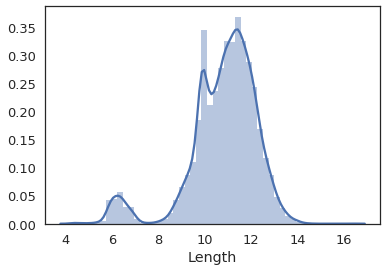

In [14]:
rpkm = pd.read_csv(outdir + './expression/rna_exp_rpkm.tsv', sep='\t')
# set rpkm index
rpkm.set_index(rpkm.columns.values[0], inplace=True)
rpkm.index.rename('refseqID', inplace=True)

# clean up column names
# rename rpkm columns
rpkm = rpkm.rename(columns=dict(zip(rpkm.iloc[:, 7:].columns.values,
                                    pd.Series(rpkm.iloc[:, 7:].columns.values).str[:-5].str.split('/').str[-1])))
sns.distplot(np.log2(rpkm.Length + 1))

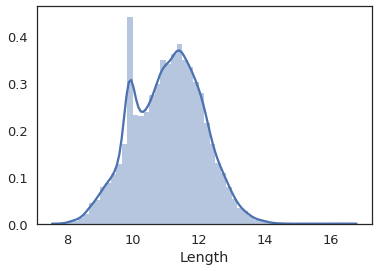

In [15]:
# Filter small mRNAs (transcriptsdd with length < 250 - mostly snoRNAs)
rpkm = rpkm.loc[rpkm.Length >= 250, :]
sns.distplot(np.log2(rpkm.Length + 1))

### Create a sample datasheet

In [16]:
samples = pd.Series(rpkm.iloc[:, 7:].columns.values)
cage = samples.str.split('_').str[-1]
group = ['_'.join(i) for i in samples.str.split('_').str[:-1]]

samplesDF = pd.DataFrame([pd.Series(samples),
              pd.Series(cage),
              pd.Series(group)],
              index=['sample', 'cage', 'group']).T

### Convert to tpm

In [17]:
tpm_mat = (rpkm.iloc[:, 7:] / rpkm.iloc[:, 7:].sum()) * 1000000

In [18]:
# create avg tpm matrix for filtering
tpm_avg = pd.DataFrame([
    tpm_mat.loc[:, list(samplesDF.group.str.contains('AMLNDiet_1wk'))].mean(1),
    tpm_mat.loc[:, list(samplesDF.group.str.contains('AMLNDiet_10wk'))].mean(1),
    tpm_mat.loc[:, list(samplesDF.group.str.contains('AMLNDiet_20wk'))].mean(1),
    tpm_mat.loc[:, list(samplesDF.group.str.contains('AMLNDiet_30wk'))].mean(1),
    tpm_mat.loc[:, list(samplesDF.group.str.contains('AMLNDiet_4wk'))].mean(1),
    tpm_mat.loc[:, list(samplesDF.group.str.contains('Control_0wk'))].mean(1),
    tpm_mat.loc[:, list(samplesDF.group.str.contains('Control_20wk'))].mean(1)],
    index=['AMLNDiet_1wk', 'AMLNDiet_10wk', 'AMLNDiet_20wk',
           'AMLNDiet_30wk', 'AMLNDiet_4wk', 'Control_0wk',
           'Control_20wk']).T

# filter genes not expressed at least 1 tpm across more than half of samples
tpm_filt = tpm_mat.loc[(tpm_avg > 9).any(1), :]

# change index to gene names
tpm_filt = tpm_filt.merge(mm10_refseq, how='left', left_index=True, right_index=True).drop_duplicates()
tpm_filt = tpm_filt.reset_index().set_index('gene').drop(columns='index')

# sort columns (manually for now)
cols = tpm_filt.columns.values
tpm_mat_filt = tpm_filt.reindex([cols[15],
                      cols[14], cols[3], cols[4],
                      cols[12], cols[13], cols[0],
                      cols[1], cols[2], cols[5],
                      cols[6], cols[7], cols[8],
                      cols[9], cols[10], cols[11]],
                      axis=1)

tpm_mat_zscore = tpm_mat_filt.apply(lambda x: (x - x.mean()) / x.std(), axis=1)

# Descriptive analysis of our data

In [19]:
# Import packages for PCA analysis
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA # uses SVD

# standardize matrix, mean=0, std=1
tpm_std = StandardScaler().fit_transform(tpm_filt)
# run PCA
pca = PCA(n_components=3)
tpm_pca = pca.fit_transform(tpm_std.T)
exp_var = pca.explained_variance_ratio_
#create df for plotting
tpm_pca_df = pd.DataFrame(tpm_pca, columns=['PC1', 'PC2', 'PC3'],
        index=([samplesDF.group])).reset_index()
tpm_pca_df['cage'] = samplesDF['cage']

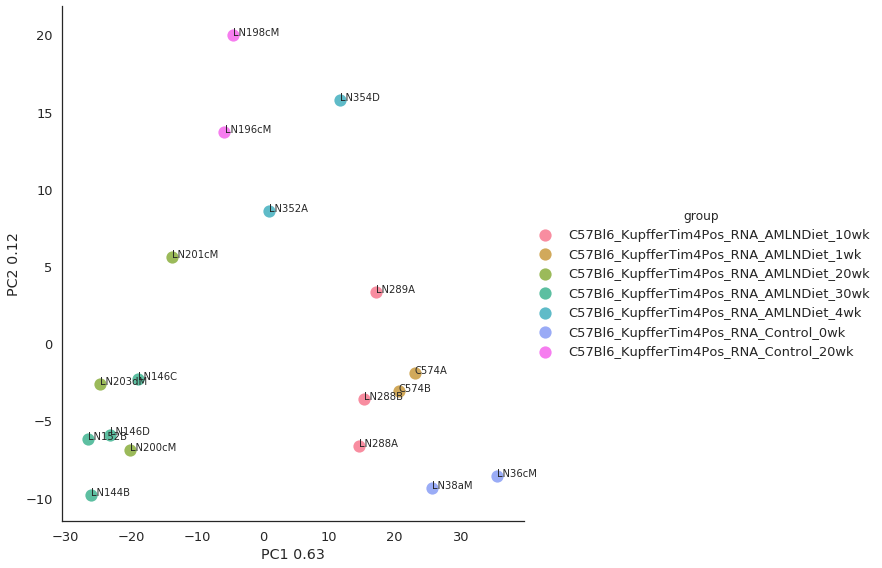

In [20]:
ax = sns.lmplot('PC1', 'PC2', tpm_pca_df, fit_reg=False,
                hue='group', # palette=color_dict,
                size=8, scatter_kws={'s': 150},
                legend=True)
ax.set(xlabel=('PC1 %.2f' % exp_var[0]), ylabel=('PC2 %.2f' % exp_var[1]))
label_point(tpm_pca_df.PC1, tpm_pca_df.PC2, tpm_pca_df.cage, plt.gca())

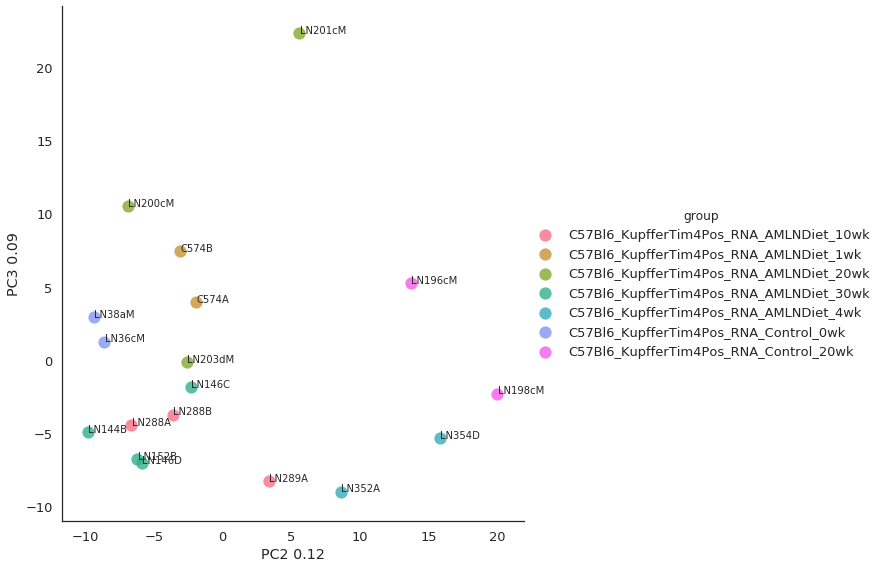

In [21]:
ax = sns.lmplot('PC2', 'PC3', tpm_pca_df, fit_reg=False,
                hue='group', # palette=color_dict,
                size=8, scatter_kws={'s': 150})
ax.set(xlabel=('PC2 %.2f' % exp_var[1]), ylabel=('PC3 %.2f' % exp_var[2]))
label_point(tpm_pca_df.PC2, tpm_pca_df.PC3, tpm_pca_df.cage, plt.gca())

In [24]:
# look at the genes with the highest loading in PC1
transcript_pc = pd.DataFrame(pca.components_.T, tpm_filt.index, columns=['PC1','PC2','PC3'])
transcript_pc.sort_values(by = 'PC1', ascending=False).head(10)

,PC1,PC2,PC3
gene,,,
Tmsb4x,0.395344,-0.367882,-0.263252
Clec4f,0.324836,0.079709,-0.040796
C1qa,0.184943,0.020683,-0.172383
Fcna,0.184548,0.058080,-0.014197
Cd5l,0.179051,0.043795,0.179173
B2m,0.161825,-0.210091,-0.002480
Wfdc17,0.157099,-0.067631,0.023352
C1qc,0.152896,0.003673,-0.042712
Vsig4,0.137007,-0.053089,-0.026934


### Heatmap

/home/h1bennet/anaconda3/envs/deseq/lib/python3.6/site-packages/seaborn/matrix.py:603: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)


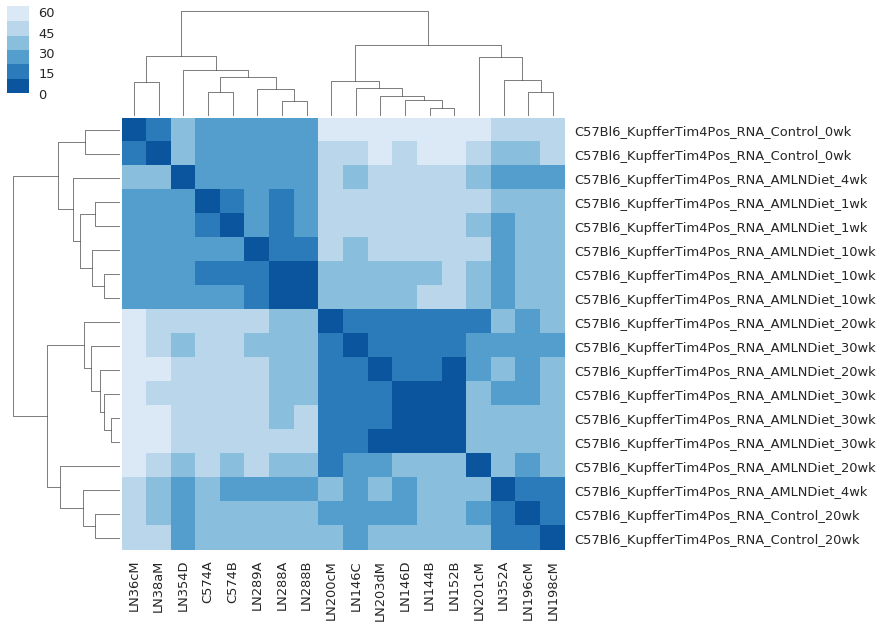

In [25]:
from scipy.spatial import distance
tpm_dist = pd.DataFrame(distance.squareform(distance.pdist(tpm_std.T, 'euclidean')),
                        columns = list(samplesDF.cage),
                        index = list(samplesDF.group))
# plot values using sns clustermap - ignore error as we know we are putting in a distance mat
g = sns.clustermap(tpm_dist, cmap=sns.color_palette("Blues_r"))

### Cluster most variable genes - top 10k, 1k

In [26]:
var_rank = tpm_filt.var(1).rank(ascending=False)

Top 10000

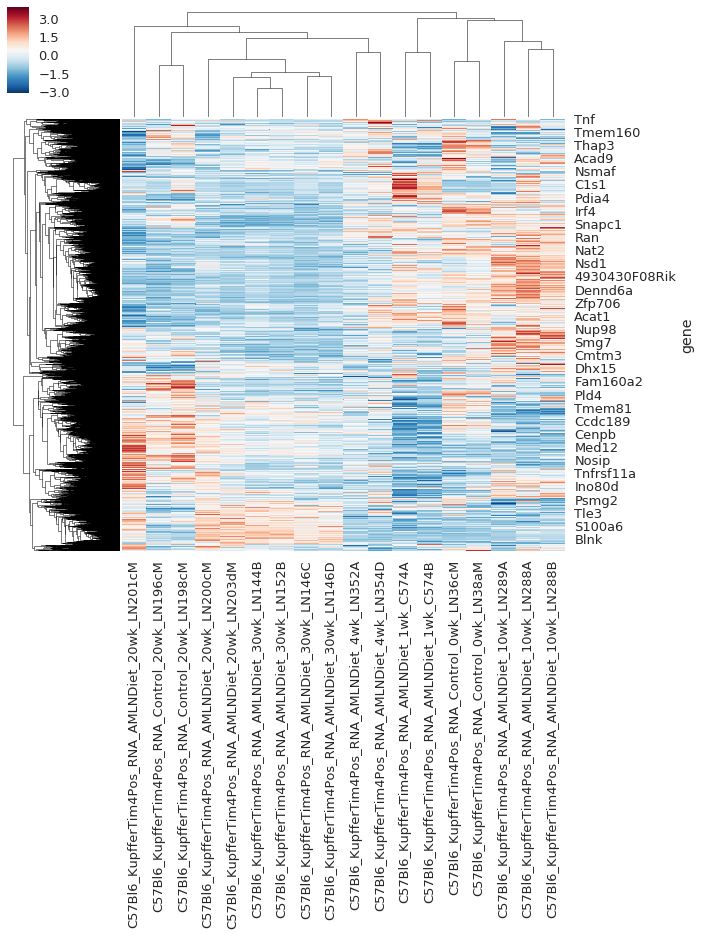

In [27]:
sns.clustermap(
    tpm_filt.loc[var_rank <= 10000, :],
    z_score=0,
    cmap='RdBu_r')
    # col_cluster=False)

Top 1000

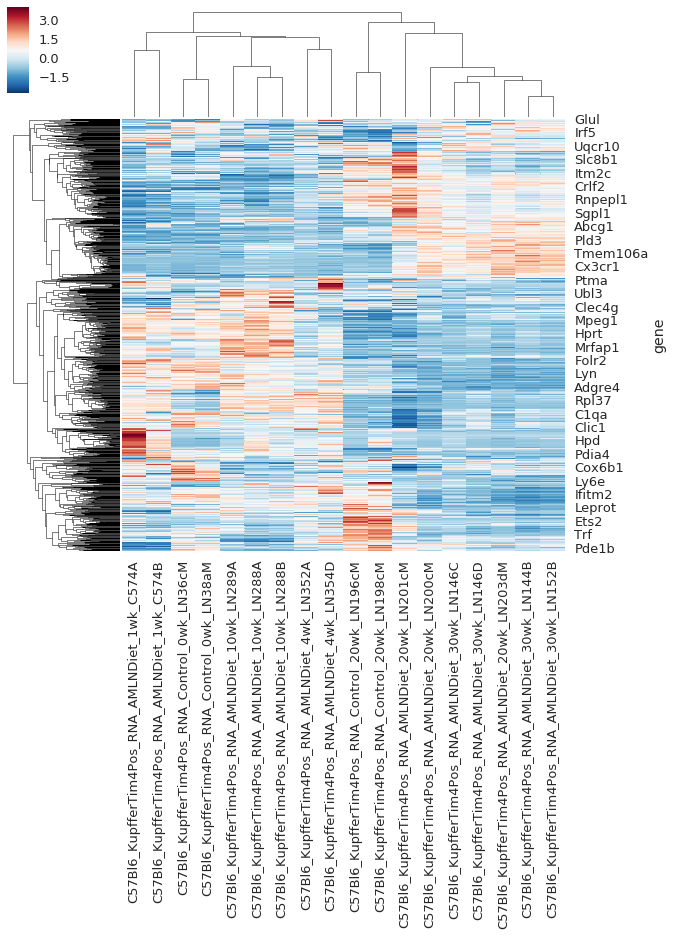

In [28]:
sns.clustermap(
    tpm_filt.loc[var_rank <= 1000, :],
    z_score=0,
    cmap='RdBu_r')
    # col_cluster=False)

# Import DESeq2 results

In [29]:
def pull_comparision(diff_gene, comp):
    return diff_gene.loc[:, [comp + ' Log2 Fold Change',
                            comp + ' p-value',
                            comp + ' adj. p-value']]

# extract groups
comp_dict = {}
pattern='(\w* vs. \w*).*'
for col in diff_gene.columns.values:
    m = re.search(string=col, pattern=pattern)
    if m:
        df = pull_comparision(diff_gene, m.group(1))
        df.columns = ['log2fc', 'pval', 'adj_pval']
        comp_dict[re.sub('G0[0-9]_', '', m.group(1))] = df        

### Set p value and fc cutoffs

In [30]:
#### Write gene list for analysis with metascape
pval = 0.01 # p value cutoff
fc = 1 # fc cutoff for interesting genes
fc_max = 1.3 # max fc to define as unchanged

### explore genes that are up at each time point relative to control
_____
Easiest way to do this: pick out significantly upregulated genes at 1wk then ones that have low fold change (maybe w/in 1.3?) between 1 week and all other samples

# 1 week

In [64]:
onewk_up = ( comp_dict['1wk vs. 0wk_control'].adj_pval <= pval ) & \
( comp_dict['1wk vs. 0wk_control'].log2fc <= -fc )

onewk_up_perm = ( comp_dict['1wk vs. 0wk_control'].adj_pval <= pval ) & \
    ( comp_dict['1wk vs. 0wk_control'].log2fc <= -fc ) & \
    ( np.abs(comp_dict['1wk vs. 4wk'].log2fc) <= np.log2(fc_max) ) & \
    ( np.abs(comp_dict['10wk vs. 1wk'].log2fc) <= np.log2(fc_max) ) & \
    ( np.abs(comp_dict['1wk vs. 20wk'].log2fc) <= np.log2(fc_max) ) & \
    ( np.abs(comp_dict['1wk vs. 30wk'].log2fc) <= np.log2(fc_max) )

onewk_dn = ( comp_dict['1wk vs. 0wk_control'].adj_pval <= pval ) & \
( comp_dict['1wk vs. 0wk_control'].log2fc >= fc )

onewk_dn_perm = ( comp_dict['1wk vs. 0wk_control'].adj_pval <= pval ) & \
    ( comp_dict['1wk vs. 0wk_control'].log2fc >= fc ) & \
    ( np.abs(comp_dict['1wk vs. 4wk'].log2fc) <= np.log2(fc_max) ) & \
    ( np.abs(comp_dict['10wk vs. 1wk'].log2fc) <= np.log2(fc_max) ) & \
    ( np.abs(comp_dict['1wk vs. 20wk'].log2fc) <= np.log2(fc_max) ) & \
    ( np.abs(comp_dict['1wk vs. 30wk'].log2fc) <= np.log2(fc_max) )
    
with open('./expression/tim4pos_1wk_up_fc2_p01.txt', 'w') as f:
    for val in onewk_up[onewk_up].index.values:
        f.write(val+'\n')
f.close()

with open('./expression/tim4pos_1wk_dn_fc2_p01.txt', 'w') as f:
    for val in onewk_dn[onewk_dn].index.values:
        f.write(val+'\n')
f.close()

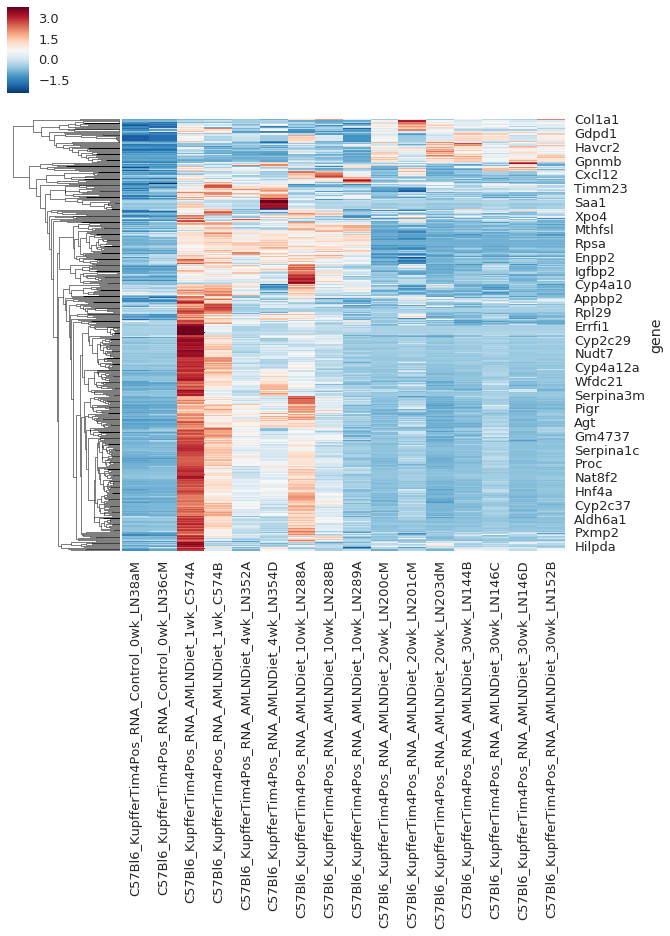

In [65]:
sns.clustermap(
    tpm_mat_filt[tpm_mat_filt.index.isin(onewk_up[onewk_up].index.values)],
    z_score=0,
    cmap='RdBu_r',
    col_cluster=False)

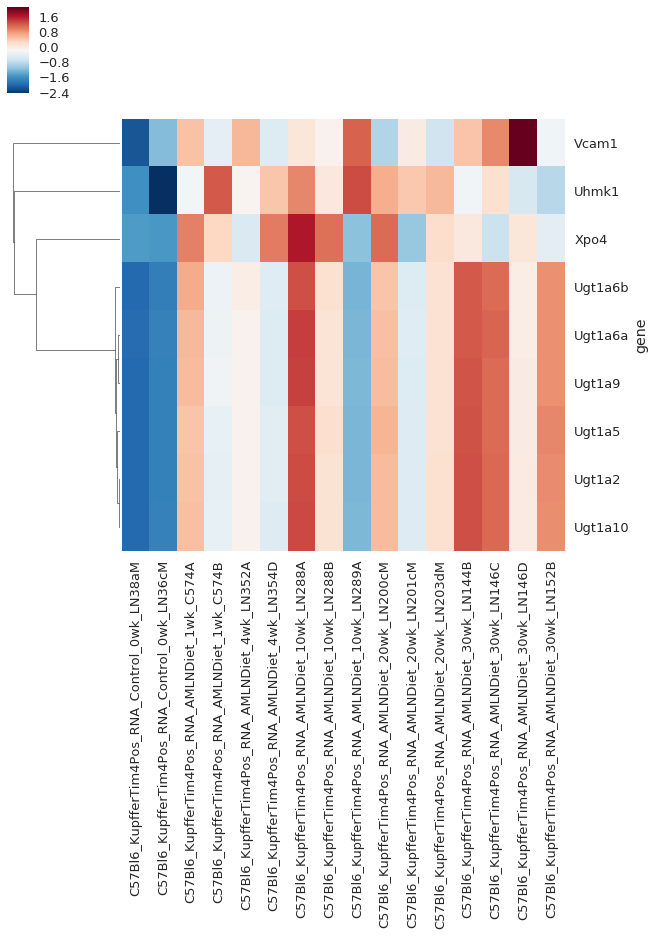

In [66]:
sns.clustermap(
    tpm_mat_filt[tpm_mat_filt.index.isin(onewk_up_perm[onewk_up_perm].index.values)],
    z_score=0,
    cmap='RdBu_r',
    col_cluster=False)

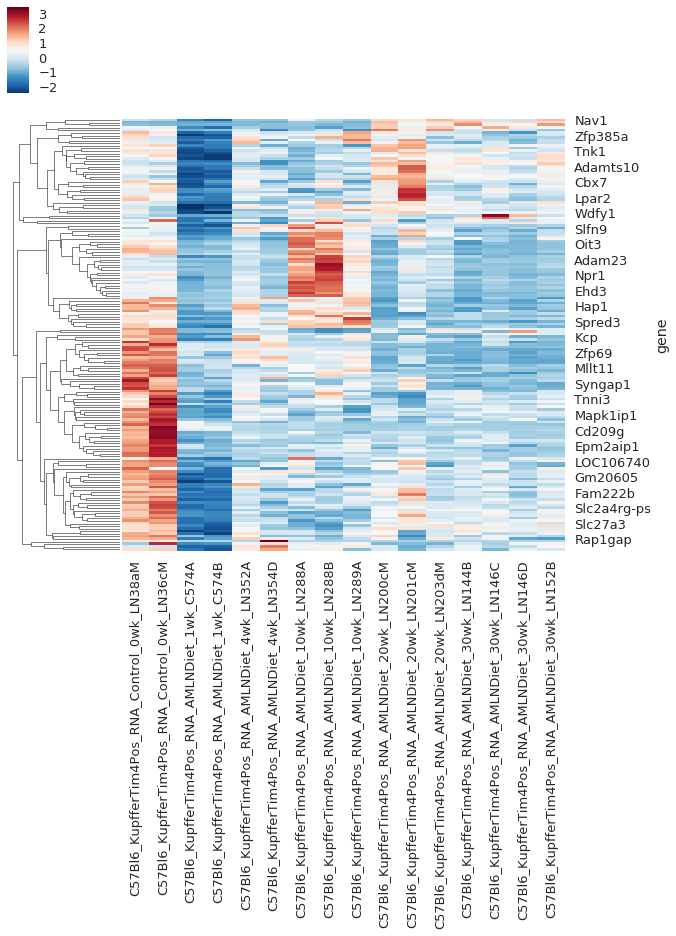

In [67]:
sns.clustermap(
    tpm_mat_filt[tpm_mat_filt.index.isin(onewk_dn[onewk_dn].index.values)],
    z_score=0,
    cmap='RdBu_r',
    col_cluster=False)

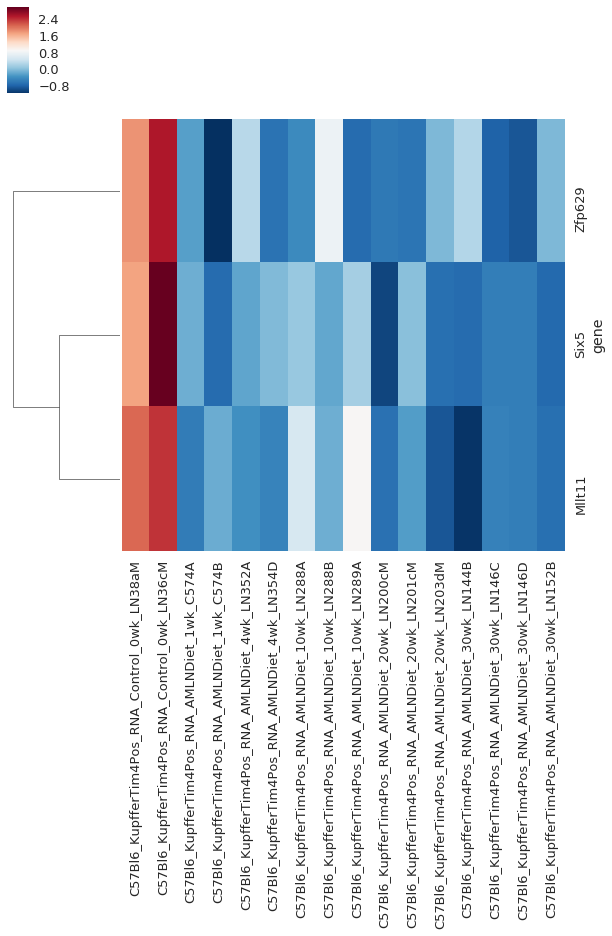

In [68]:
sns.clustermap(
    tpm_mat_filt[tpm_mat_filt.index.isin(onewk_dn_perm[onewk_dn_perm].index.values)],
    z_score=0,
    cmap='RdBu_r',
    col_cluster=False)

# Four week

In [69]:
fourwk_up = ( comp_dict['1wk vs. 4wk'].adj_pval <= pval ) & \
    ( comp_dict['1wk vs. 4wk'].log2fc >= fc )

fourwk_up_perm = ( comp_dict['1wk vs. 4wk'].adj_pval <= pval ) & \
    ( comp_dict['1wk vs. 4wk'].log2fc >= fc ) & \
    ( np.abs(comp_dict['10wk vs. 4wk'].log2fc) <= np.log2(fc_max) ) & \
    ( np.abs(comp_dict['20wk vs. 4wk'].log2fc) <= np.log2(fc_max) ) & \
    ( np.abs(comp_dict['30wk vs. 4wk'].log2fc) <= np.log2(fc_max) )
    
fourwk_dn = ( comp_dict['1wk vs. 4wk'].adj_pval <= pval ) & \
    ( comp_dict['1wk vs. 4wk'].log2fc <= -fc )

fourwk_dn_perm = ( comp_dict['1wk vs. 4wk'].adj_pval <= pval ) & \
    ( comp_dict['1wk vs. 4wk'].log2fc <= -fc ) & \
    ( np.abs(comp_dict['10wk vs. 4wk'].log2fc) <= np.log2(fc_max) ) & \
    ( np.abs(comp_dict['20wk vs. 4wk'].log2fc) <= np.log2(fc_max) ) & \
    ( np.abs(comp_dict['30wk vs. 4wk'].log2fc) <= np.log2(fc_max) )
    
with open('./expression/tim4pos_4wk_up_fc2_p01.txt', 'w') as f:
    for val in fourwk_up[fourwk_up].index.values:
        f.write(val+'\n')
f.close()

with open('./expression/tim4pos_4wk_dn_fc2_p01.txt', 'w') as f:
    for val in fourwk_dn[fourwk_dn].index.values:
        f.write(val+'\n')
f.close()

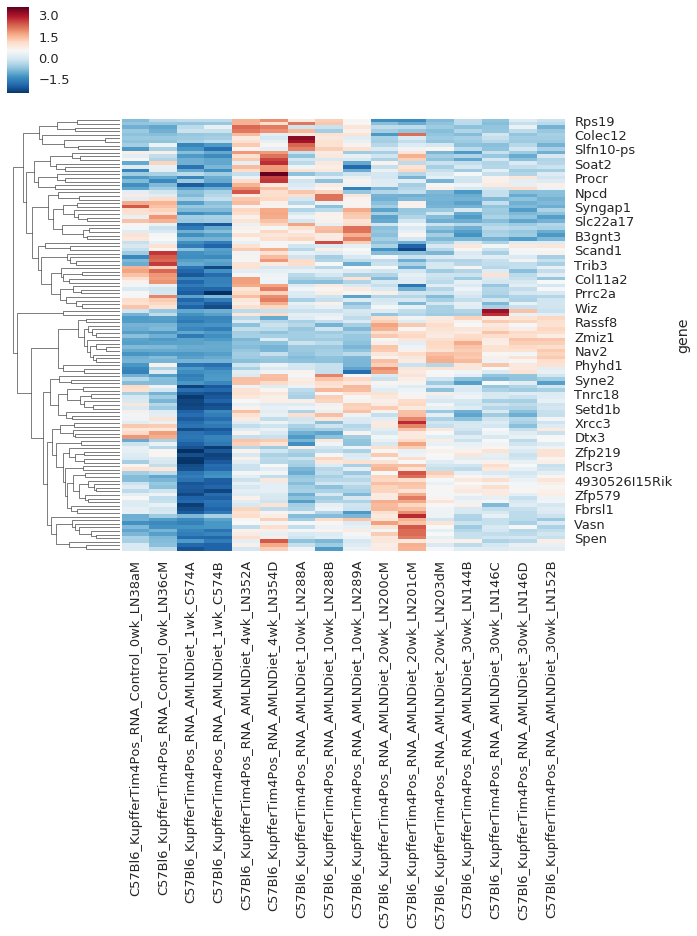

In [70]:
sns.clustermap(
    tpm_mat_filt[tpm_mat_filt.index.isin(fourwk_up[fourwk_up].index.values)],
    z_score=0,
    cmap='RdBu_r',
    col_cluster=False)

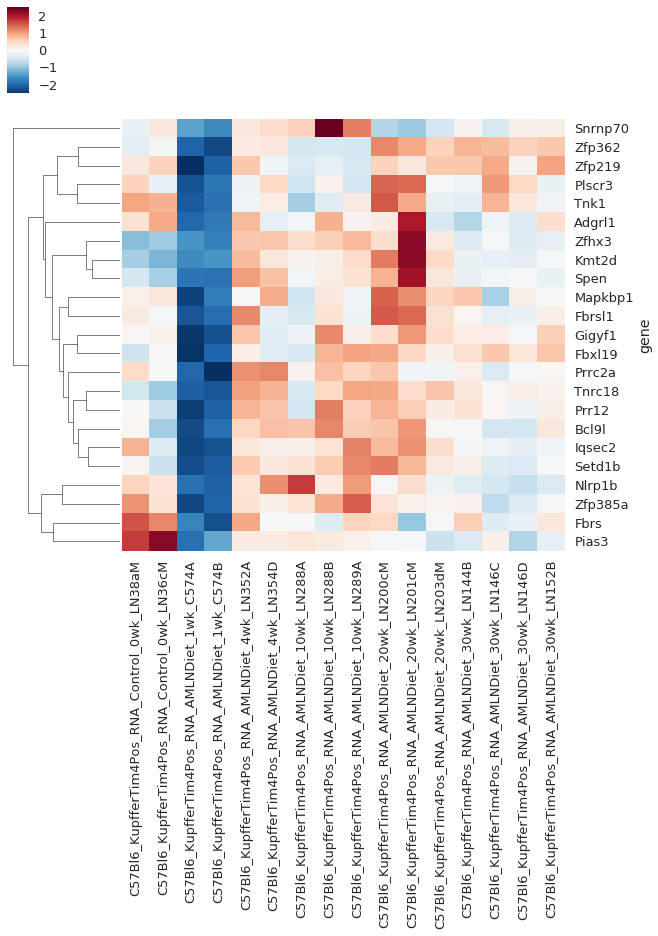

In [71]:
# could there be interesting transiet downregulation at 1 wk?
sns.clustermap(
    tpm_mat_filt[tpm_mat_filt.index.isin(fourwk_up_perm[fourwk_up_perm].index.values)],
    z_score=0,
    cmap='RdBu_r',
    col_cluster=False)

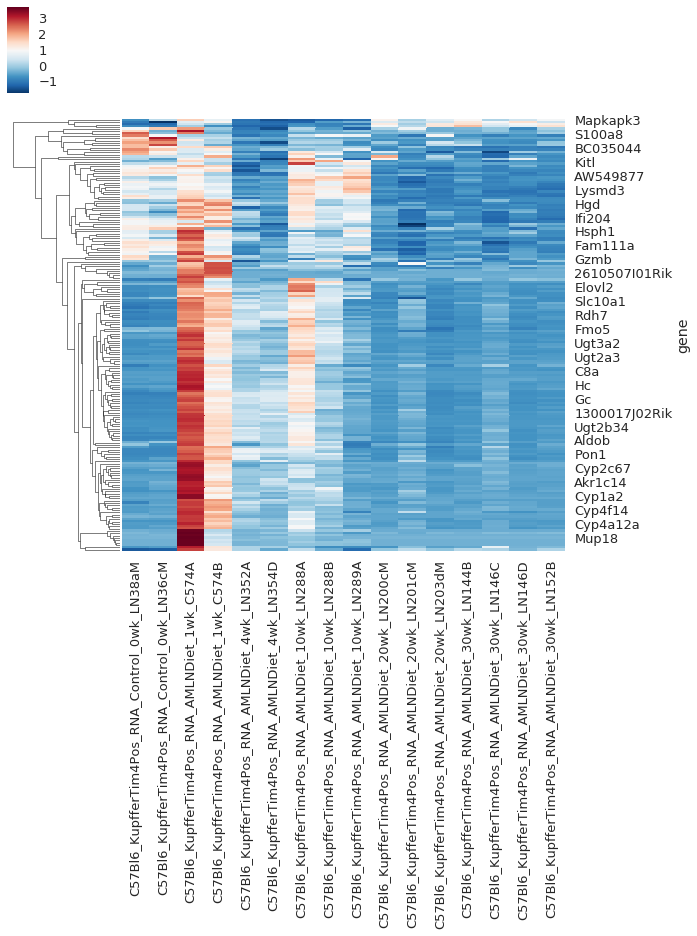

In [72]:
sns.clustermap(
    tpm_mat_filt[tpm_mat_filt.index.isin(fourwk_dn[fourwk_dn].index.values)],
    z_score=0,
    cmap='RdBu_r',
    col_cluster=False)

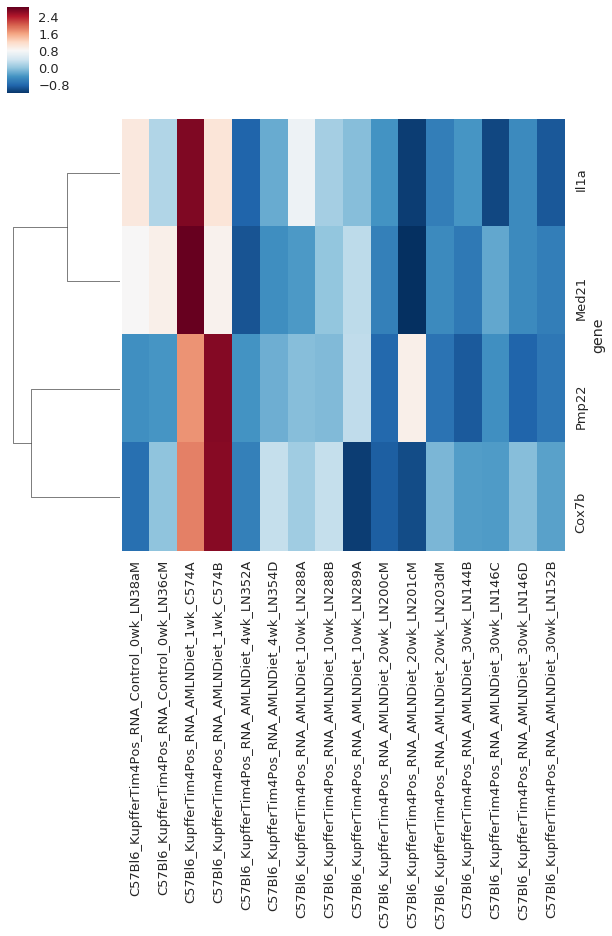

In [73]:
# could there be interesting transiet downregulation at 1 wk?
sns.clustermap(
    tpm_mat_filt[tpm_mat_filt.index.isin(fourwk_dn_perm[fourwk_dn_perm].index.values)],
    z_score=0,
    cmap='RdBu_r',
    col_cluster=False)

# 10 week

In [74]:
tenwk_up = ( comp_dict['10wk vs. 4wk'].adj_pval <= pval ) & \
    ( comp_dict['10wk vs. 4wk'].log2fc <= -fc )
    
tenwk_up_perm = ( comp_dict['10wk vs. 4wk'].adj_pval <= pval ) & \
    ( comp_dict['10wk vs. 4wk'].log2fc <= -fc ) & \
    ( np.abs(comp_dict['10wk vs. 20wk'].log2fc) <= np.log2(fc_max) ) & \
    ( np.abs(comp_dict['10wk vs. 30wk'].log2fc) <= np.log2(fc_max) )
    
tenwk_dn = ( comp_dict['10wk vs. 4wk'].adj_pval <= pval ) & \
    ( comp_dict['10wk vs. 4wk'].log2fc >= fc )
    
tenwk_dn_perm = ( comp_dict['10wk vs. 4wk'].adj_pval <= pval ) & \
    ( comp_dict['10wk vs. 4wk'].log2fc >= fc ) & \
    ( np.abs(comp_dict['10wk vs. 20wk'].log2fc) <= np.log2(fc_max) ) & \
    ( np.abs(comp_dict['10wk vs. 30wk'].log2fc) <= np.log2(fc_max) )
    
with open('./expression/tim4pos_10wk_up_fc2_p01.txt', 'w') as f:
    for val in tenwk_up[tenwk_up].index.values:
        f.write(val+'\n')
f.close()

with open('./expression/tim4pos_10wk_dn_fc2_p01.txt', 'w') as f:
    for val in tenwk_dn[tenwk_dn].index.values:
        f.write(val+'\n')
f.close()

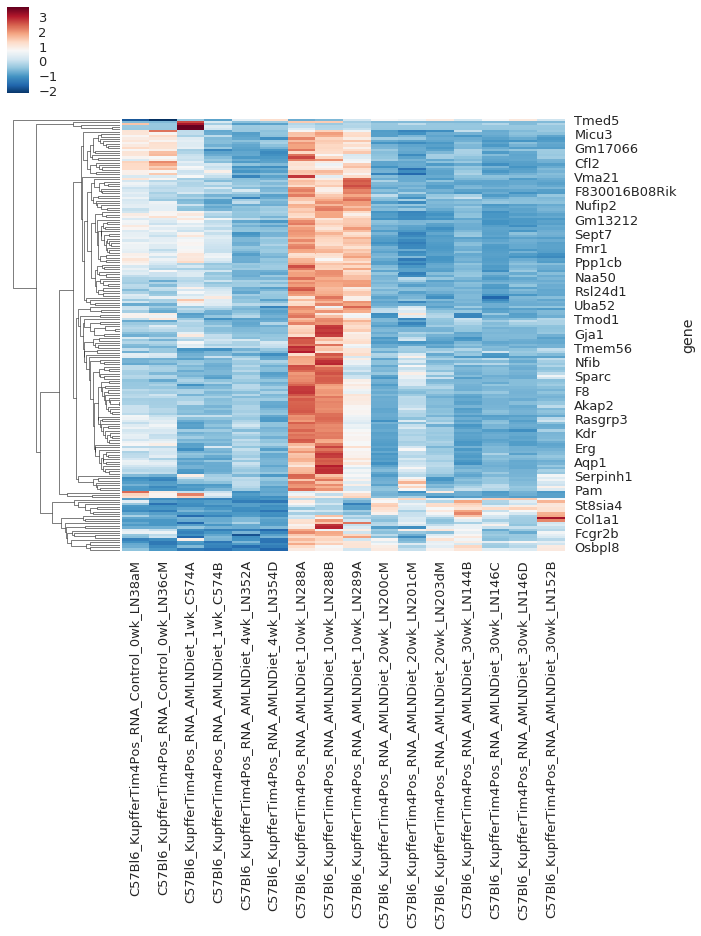

In [75]:
sns.clustermap(
    tpm_mat_filt[tpm_mat_filt.index.isin(tenwk_up[tenwk_up].index.values)],
    z_score=0,
    cmap='RdBu_r',
    col_cluster=False)

** At 10 weeks we see CD36 turned on - scavenger receptor/lipid uptake membrane protein**  
Expression more than doubles at 10 weeks and stays ~ 2x as high at 20 and 30 weeks

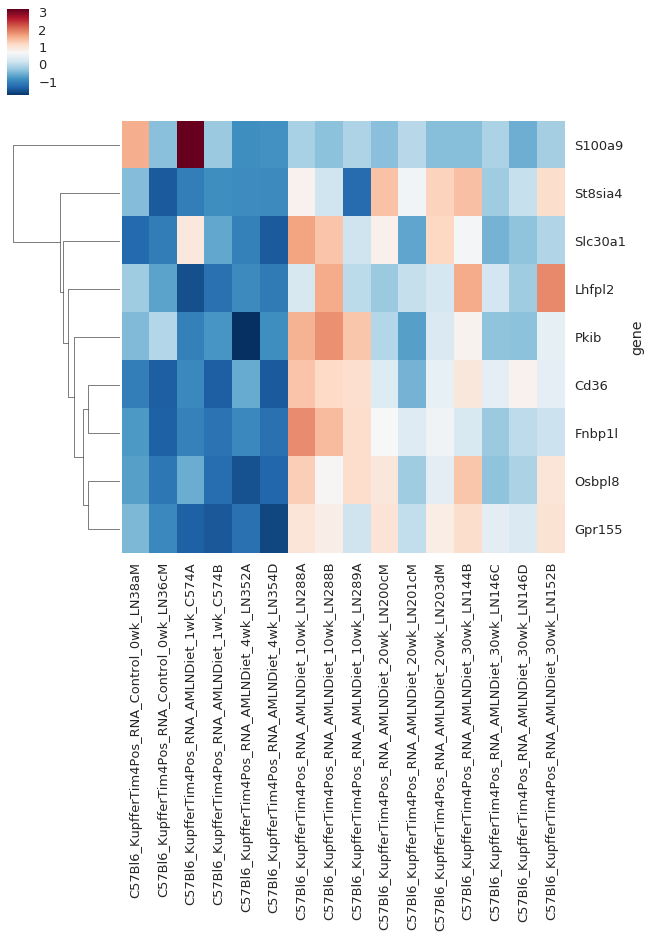

In [76]:
sns.clustermap(
    tpm_mat_filt[tpm_mat_filt.index.isin(tenwk_up_perm[tenwk_up_perm].index.values)],
    z_score=0,
    cmap='RdBu_r',
    col_cluster=False)

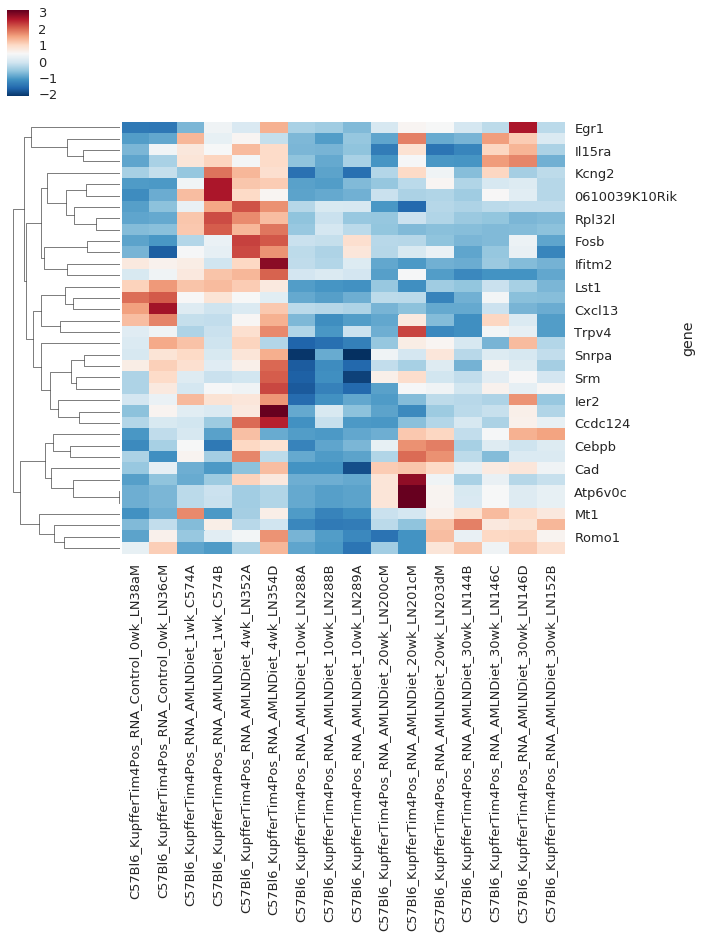

In [77]:
sns.clustermap(
    tpm_mat_filt[tpm_mat_filt.index.isin(tenwk_dn[tenwk_dn].index.values)],
    z_score=0,
    cmap='RdBu_r',
    col_cluster=False)

ValueError: zero-size array to reduction operation minimum which has no identity

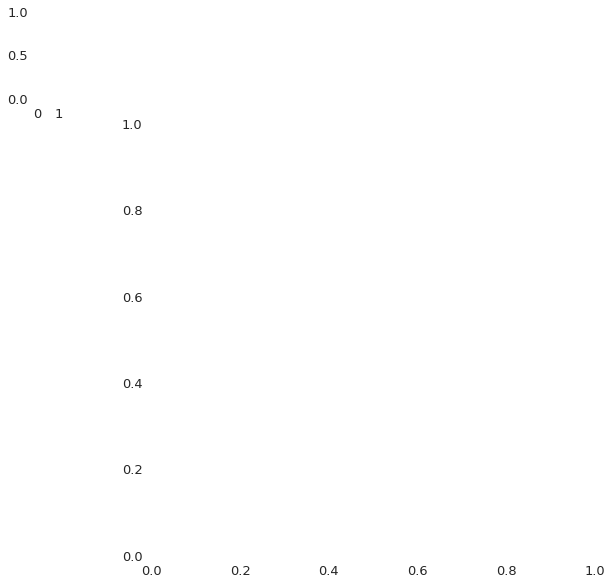

In [51]:
sns.clustermap(
    tpm_mat_filt[tpm_mat_filt.index.isin(tenwk_dn_perm[tenwk_dn_perm].index.values)],
    z_score=0,
    cmap='RdBu_r',
    col_cluster=False)

# 20 weeks

In [78]:
twentywk_up = ( comp_dict['10wk vs. 20wk'].adj_pval <= pval ) & \
    ( comp_dict['10wk vs. 20wk'].log2fc >= fc )
    
twentywk_up_perm = ( comp_dict['10wk vs. 20wk'].adj_pval <= pval ) & \
    ( comp_dict['10wk vs. 20wk'].log2fc >= fc ) & \
    ( np.abs(comp_dict['20wk vs. 30wk'].log2fc) <= np.log2(fc_max) )

twentywk_dn = ( comp_dict['10wk vs. 20wk'].adj_pval <= pval ) & \
    ( comp_dict['10wk vs. 20wk'].log2fc <= -fc )

twentywk_dn_perm = ( comp_dict['10wk vs. 20wk'].adj_pval <= pval ) & \
    ( comp_dict['10wk vs. 20wk'].log2fc <= -fc ) & \
    ( np.abs(comp_dict['20wk vs. 30wk'].log2fc) <= np.log2(fc_max) )

with open('./expression/tim4pos_20wk_up_fc2_p01.txt', 'w') as f:
    for val in twentywk_up[twentywk_up].index.values:
        f.write(val+'\n')
f.close()

with open('./expression/tim4pos_20wk_dn_fc2_p01.txt', 'w') as f:
    for val in twentywk_dn[twentywk_dn].index.values:
        f.write(val+'\n')
f.close()

In [79]:
twentywk = np.concatenate((twentywk_up[twentywk_up].index.values,
                          twentywk_dn[twentywk_dn].index.values))

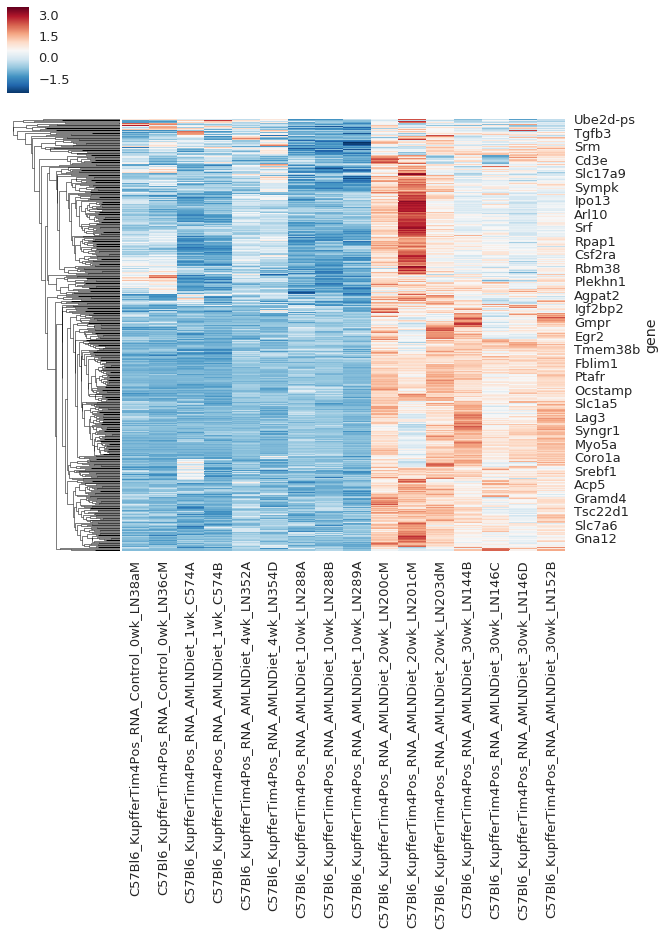

In [80]:
sns.clustermap(
    tpm_mat_filt[tpm_mat_filt.index.isin(twentywk_up[twentywk_up].index.values)],
    z_score=0,
    cmap='RdBu_r',
    col_cluster=False)

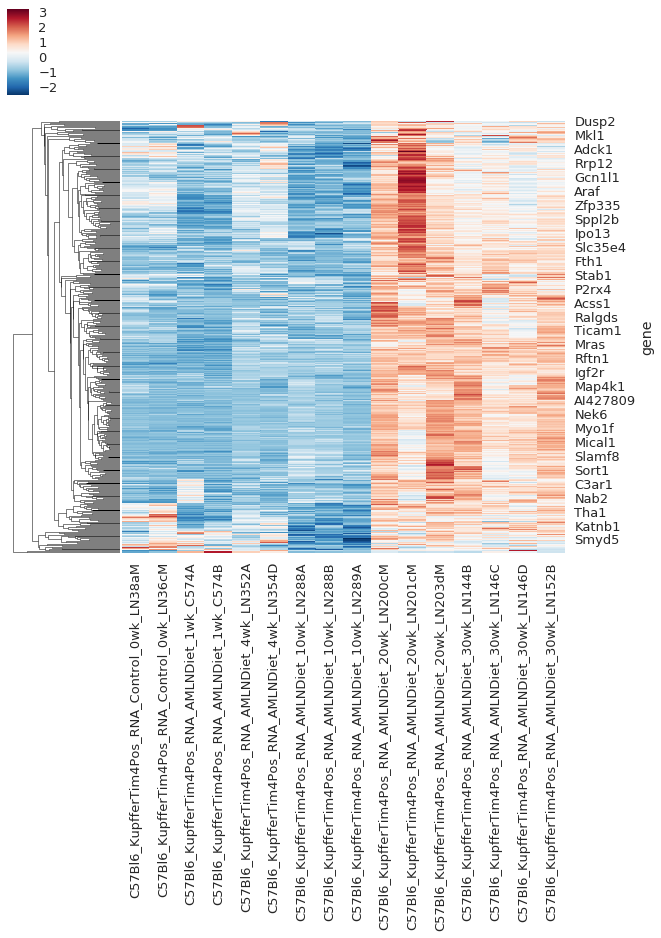

In [81]:
sns.clustermap(
    tpm_mat_filt[tpm_mat_filt.index.isin(twentywk_up_perm[twentywk_up_perm].index.values)],
    z_score=0,
    cmap='RdBu_r',
    col_cluster=False)

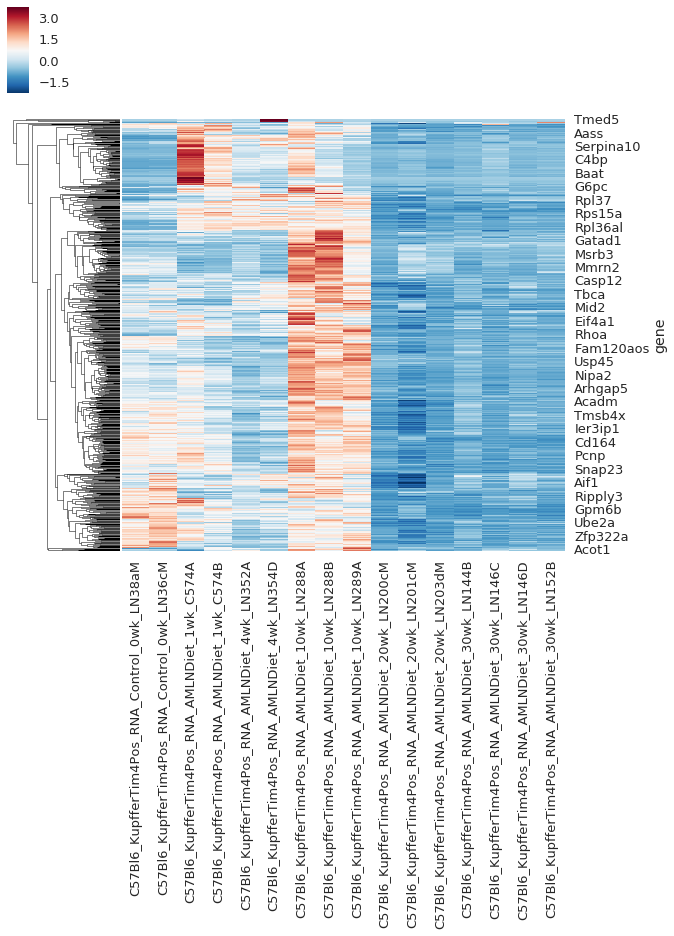

In [82]:
sns.clustermap(
    tpm_mat_filt[tpm_mat_filt.index.isin(twentywk_dn[twentywk_dn].index.values)].dropna(),
    z_score=0,
    cmap='RdBu_r',
    col_cluster=False)

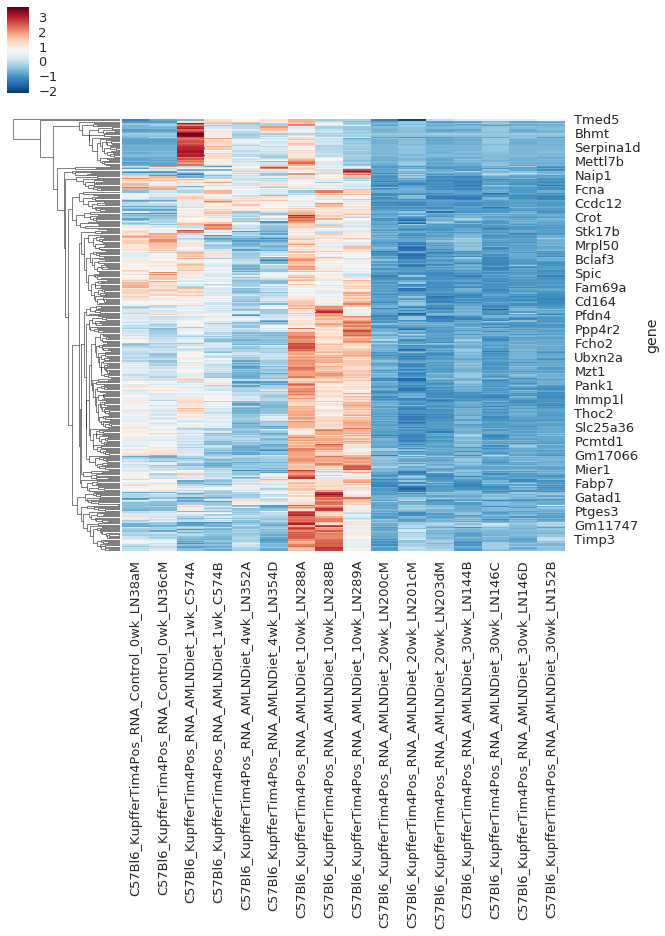

In [83]:
sns.clustermap(
    tpm_mat_filt[tpm_mat_filt.index.isin(twentywk_dn_perm[twentywk_dn_perm].index.values)].dropna(),
    z_score=0,
    cmap='RdBu_r',
    col_cluster=False)

# 30 week

In [84]:
thirtywk_up = ( comp_dict['20wk vs. 30wk'].adj_pval <= pval ) & \
    ( comp_dict['20wk vs. 30wk'].log2fc >= fc )

thirtywk_dn = ( comp_dict['20wk vs. 30wk'].adj_pval <= pval ) & \
    ( comp_dict['20wk vs. 30wk'].log2fc <= -fc )

with open('./expression/tim4pos_30wk_up_fc2_p01.txt', 'w') as f:
    for val in thirtywk_up[thirtywk_up].index.values:
        f.write(val+'\n')
f.close()

with open('./expression/tim4pos_30wk_dn_fc2_p01.txt', 'w') as f:
    for val in thirtywk_dn[thirtywk_dn].index.values:
        f.write(val+'\n')
f.close()

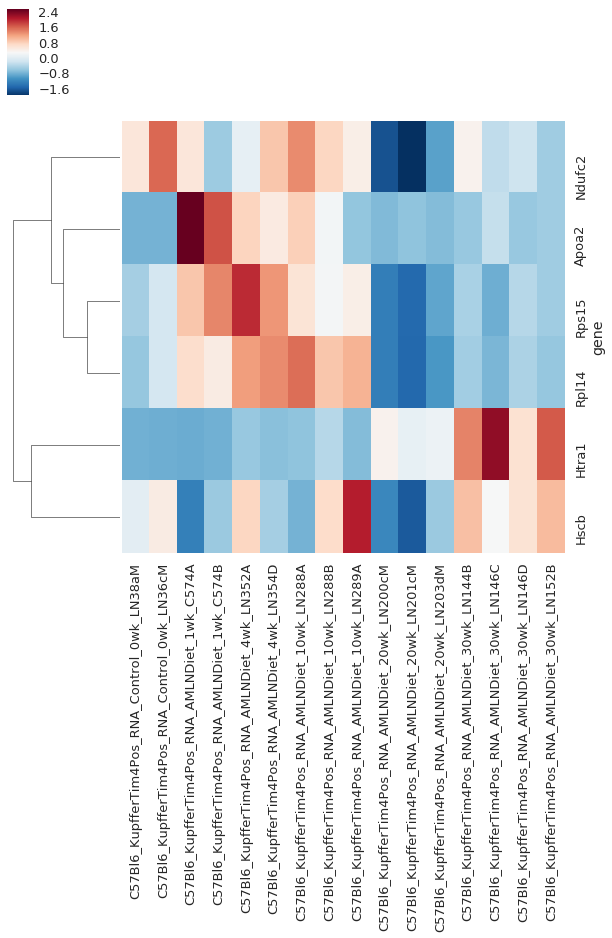

In [85]:
sns.clustermap(
    tpm_mat_filt[tpm_mat_filt.index.isin(thirtywk_up[thirtywk_up].index.values)],
    z_score=0,
    cmap='RdBu_r',
    col_cluster=False)

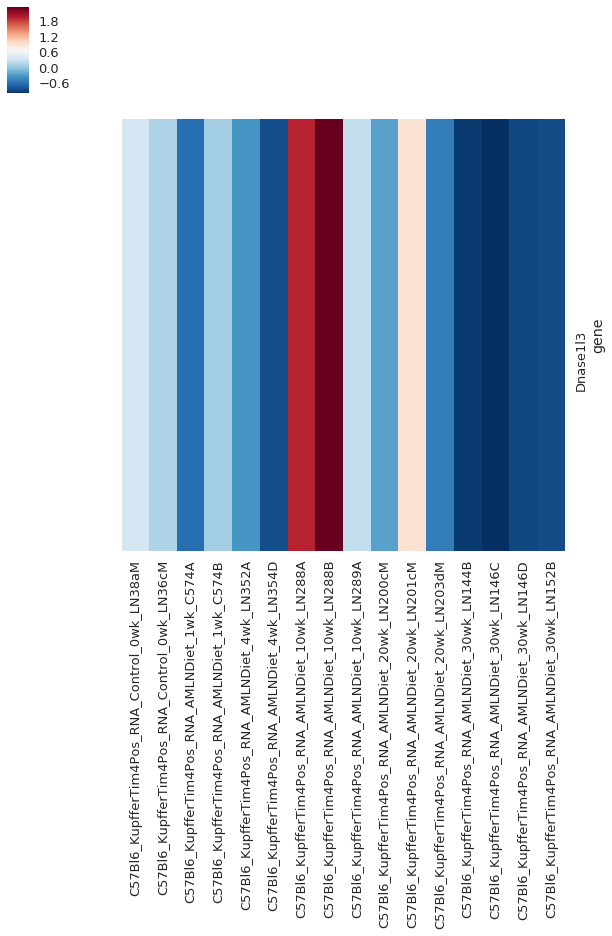

In [90]:
sns.clustermap(
    tpm_mat_filt[tpm_mat_filt.index.isin(thirtywk_dn[thirtywk_dn].index.values)],
    z_score=0,
    cmap='RdBu_r',
    col_cluster=False,
    row_cluster=False)

# Lipid metabolic genes

In [40]:
lip_met = ['Acot4', 'Acaa1b', 'Acaa2', 'Hadha', 'Acot2', 'Acox3', 'Elovl5', 'Hadh', 'Fads1',
           'Acox1', 'Ppt1', 'Tecr', 'Ppt2', 'Elovl1', 'Fasds2', 'Echs1', 'Scd2', 'Ptplb',
           'Hadhb', 'Pecr', 'Acot1', 'Mecr', 'Scd1', 'Acot7', 'Acaa1a', 'Hsd17b12', 'Elovl2',
           'Elovl7', 'Scd3', 'Scd4']

/home/h1bennet/anaconda3/envs/deseq/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  """Entry point for launching an IPython kernel.
/home/h1bennet/anaconda3/envs/deseq/lib/python3.6/site-packages/pandas/core/indexing.py:1367: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


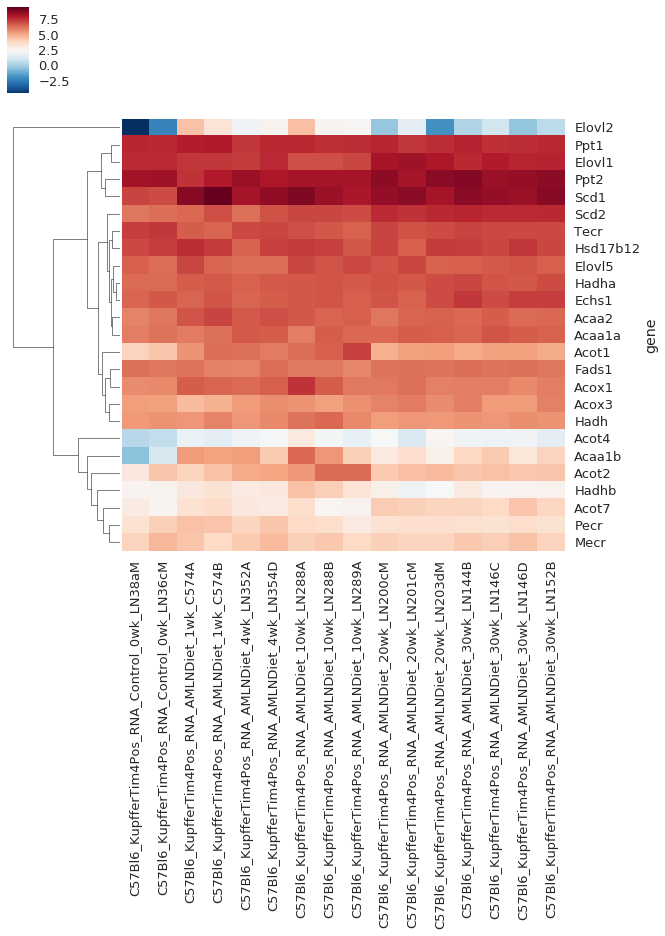

In [44]:
sns.clustermap(np.log2(tpm_mat_filt.loc[lip_met, :].dropna()),
               cmap='RdBu_r', col_cluster=False)

# KC Specific Genes

In [54]:
set(kc_genes).intersection(twentywk_dn[twentywk_dn].index.values)

{'Ambp',
 'Bank1',
 'Ccl24',
 'Chp2',
 'Clec4f',
 'Dram2',
 'Fabp7',
 'Fgg',
 'Gm4951',
 'Hpgd',
 'Icos',
 'Ifit3b',
 'Iigp1',
 'Klrk1',
 'Marcks',
 'Ogfrl1',
 'Rbp4',
 'Serpina1a',
 'Serpina1c',
 'Serpina1d',
 'Serpinc1',
 'Vtn'}

In [55]:
set(kc_genes).intersection(twentywk_up[twentywk_up].index.values)

{'Cd79b',
 'Dgkz',
 'Itgb5',
 'Nfkbid',
 'Oasl1',
 'P2rx4',
 'Pdgfa',
 'Prkar1b',
 'Rasa4',
 'Slc37a2',
 'Smyd5',
 'Tns3',
 'Tpra1'}

303
298


/home/h1bennet/anaconda3/envs/deseq/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  import sys
/home/h1bennet/anaconda3/envs/deseq/lib/python3.6/site-packages/pandas/core/indexing.py:1367: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/home/h1bennet/anaconda3/envs/deseq/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative

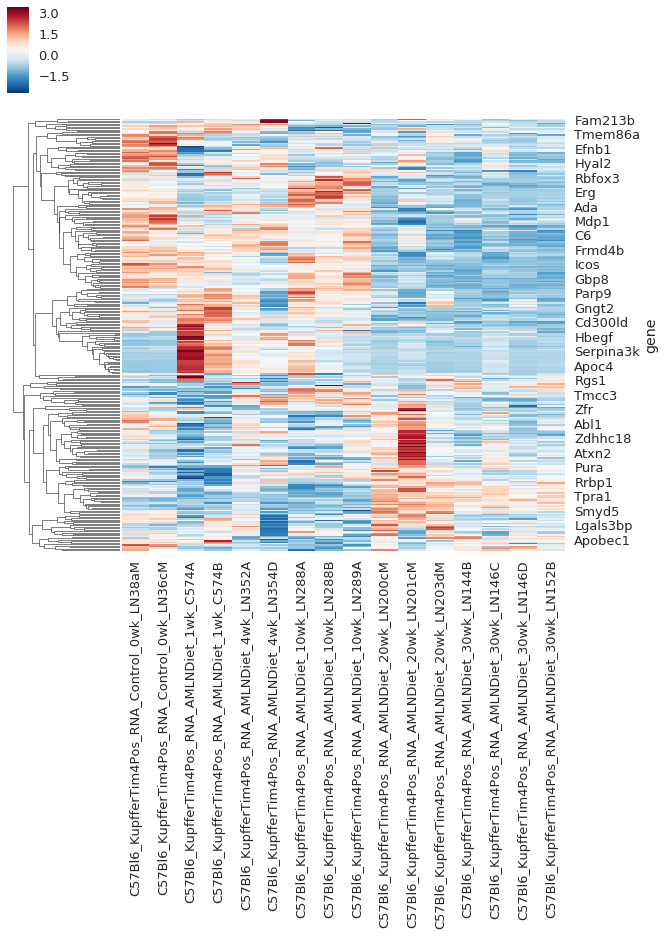

In [40]:
import scipy

with open('/home/h1bennet/liverStrains/data/mouse/kc_signature_lavin_amit', 'r') as f:
    kc_genes = [i.strip('"') for i in f.read().split()]

print(len(kc_genes))
print(tpm_mat_zscore.loc[kc_genes, :].dropna().shape[0])
rowclust = scipy.cluster.hierarchy.linkage(tpm_mat_zscore.loc[kc_genes, :].dropna(),
                                           method='average')

kc = sns.clustermap(tpm_mat_filt.loc[kc_genes, :].dropna(),
                    z_score=0, cmap='RdBu_r', col_cluster=False,
                    row_linkage=rowclust)

kc.savefig('./figures/KC_specific_C57_AJ_Balb_heatmap.png', bbox_inches='tight')

/home/h1bennet/anaconda3/envs/deseq/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  """Entry point for launching an IPython kernel.
/home/h1bennet/anaconda3/envs/deseq/lib/python3.6/site-packages/pandas/core/indexing.py:1367: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


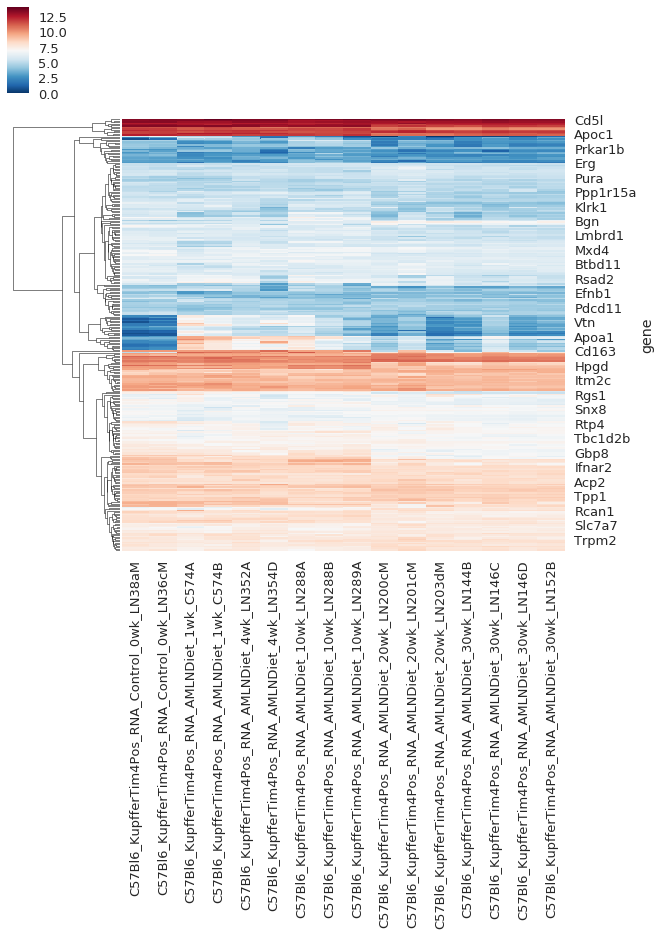

In [42]:
sns.clustermap(np.log2(tpm_mat_filt.loc[kc_genes, :].dropna()+1),
               cmap='RdBu_r', col_cluster=False)

* Mapkapk3 activated by map kinase. Phosphorylates inflammatory genes
* Ifi205 activates NLRP3 inflammasome in resposne to
* Hsd3b5 is a steroid biosynthesis pathway enzyme, Cyp4a12 is a steroid oxidizer
* Cyp2c mice involved  in conjugation and creation of bile acids.
* Rdh7 is involved in retinol metabolism

### How do KC Specific Genes change

In [26]:
row_two_clust = (scipy.cluster.hierarchy.cut_tree(rowclust, n_clusters=2) == 1)
row_two_clust = [i[0] for i in row_two_clust]

In [27]:
len(row_two_clust)

275

/home/h1bennet/anaconda3/envs/deseq/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  """Entry point for launching an IPython kernel.
/home/h1bennet/anaconda3/envs/deseq/lib/python3.6/site-packages/pandas/core/indexing.py:1367: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


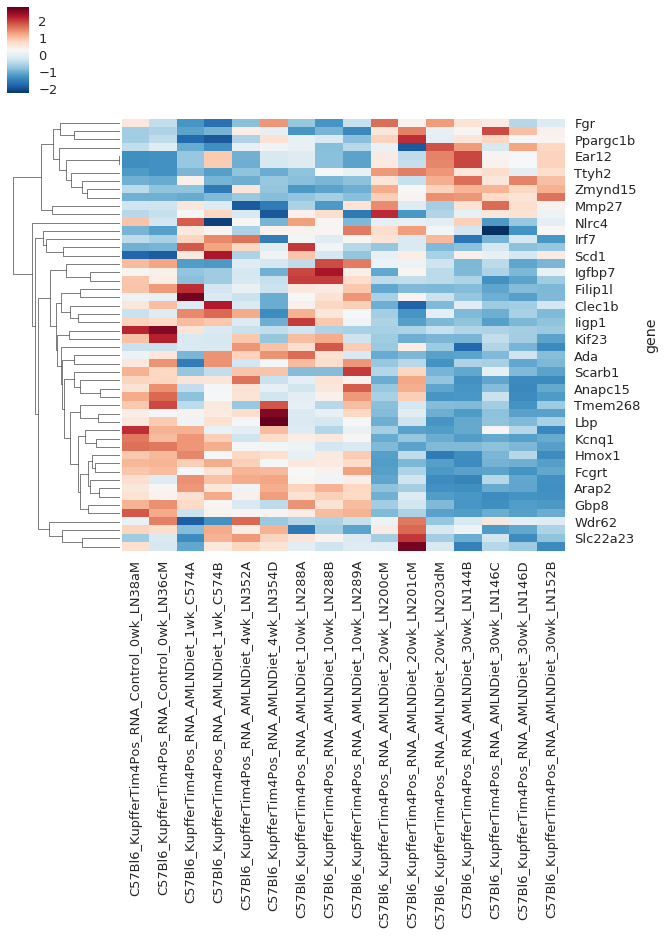

In [28]:
sns.clustermap(tpm_mat_filt.loc[kc_genes, :].loc[row_two_clust, :].dropna(),
                    z_score=0, cmap='RdBu_r', col_cluster=False)

In [29]:
de_sermut_genes = ['Nnmt', 'Hamp2', 'Thrsp',
                   'Ppp1r3g', 'Cyp2c69', 'Cyp2b13',
                   'Cyp2b9', 'Ces1f', 'Slc22a26',
                   'Bex1', 'Syngr1', 'Wfdc3',
                   'Fabp5', 'Timp1', 'Atp06vd2',
                   'Scara3', 'Obspl3', 'Cx3cr1',
                   'Col1a1', 'Spp1', 'Osbpl3',
                   'Acss3', 'Elovl3', 'Fads1',
                   'Fads2', 'Elovl5', 'Ascl1',
                   'Acox1', 'Acaa1b', 'Acad11',
                   'Acadm']

Plot genes from the mutated serine mice in the Becares et al 2017 BioRXiv paper.

Of the ones with a name that matches our gene name we see that genes that were downregulated by removing the phosphate group are upregulated in the later stages of NASH!

/home/h1bennet/anaconda3/envs/deseq/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  """Entry point for launching an IPython kernel.
/home/h1bennet/anaconda3/envs/deseq/lib/python3.6/site-packages/pandas/core/indexing.py:1367: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


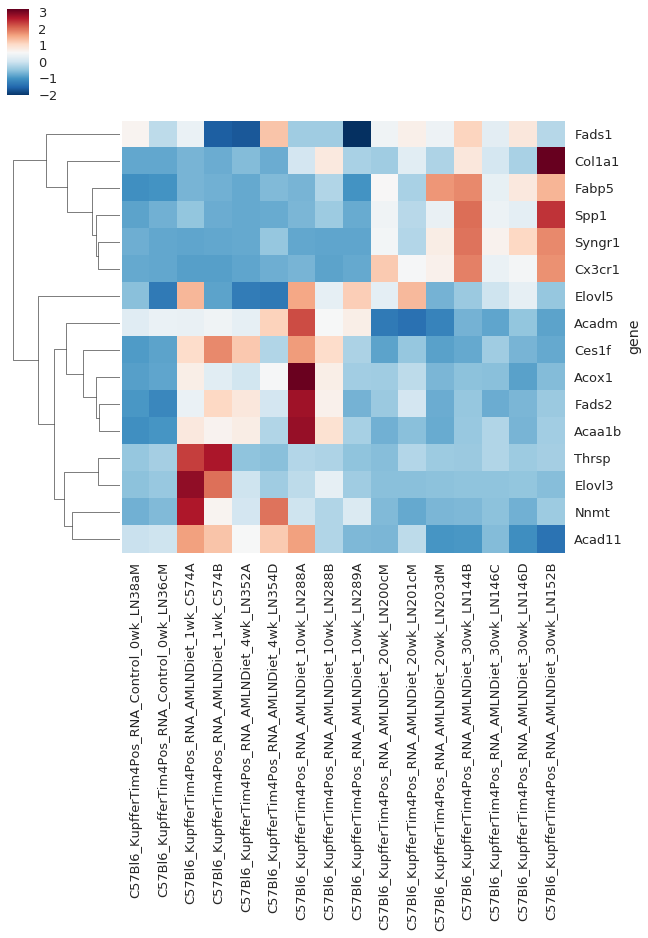

In [30]:
sns.clustermap(tpm_mat_filt.loc[de_sermut_genes, :].dropna(),
               z_score=0, cmap='RdBu_r', col_cluster=False)

# SREBP pathway

In [36]:
chol_met_proc = hbUtils.pull_go_terms("GO:0008203", taxon_id='10090', product_type='protein')
chol_met_proc = [entry[1] for entry in chol_met_proc]
chol_biosyn_proc = hbUtils.pull_go_terms("GO:0006695", taxon_id='10090', product_type='protein')
chol_biosyn_proc = [entry[1] for entry in chol_biosyn_proc]

srebp = list(set(chol_biosyn_proc + chol_met_proc))

/home/h1bennet/anaconda3/envs/deseq/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  """Entry point for launching an IPython kernel.
/home/h1bennet/anaconda3/envs/deseq/lib/python3.6/site-packages/pandas/core/indexing.py:1367: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


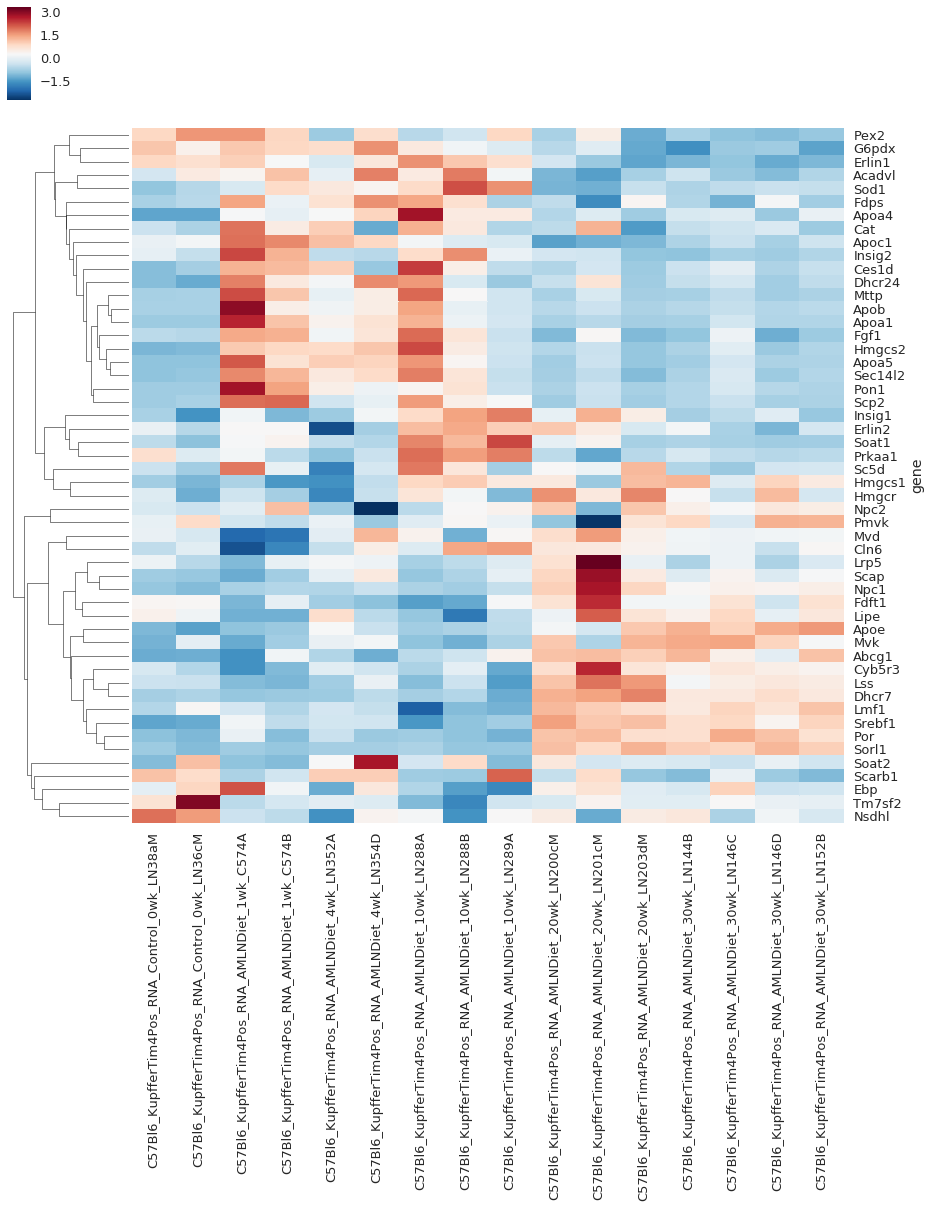

In [37]:
sns.clustermap(tpm_mat_filt.loc[srebp, :].dropna(),
               z_score=0, cmap='RdBu_r', col_cluster=False, figsize=(15,15))

# LXR Pathway

In [44]:
with open('/home/h1bennet/data/gene_lists/mouse/LXRDKODown2foldGenes.txt') as f:
    lxrko_down = [i.strip() for i in f.readlines()]
    
with open('/home/h1bennet/data/gene_lists/mouse/LXRDKOUp2foldGenes.txt') as f:
    lxrko_up = [i.strip() for i in f.readlines()]

/home/h1bennet/anaconda3/envs/deseq/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  """Entry point for launching an IPython kernel.
/home/h1bennet/anaconda3/envs/deseq/lib/python3.6/site-packages/pandas/core/indexing.py:1367: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


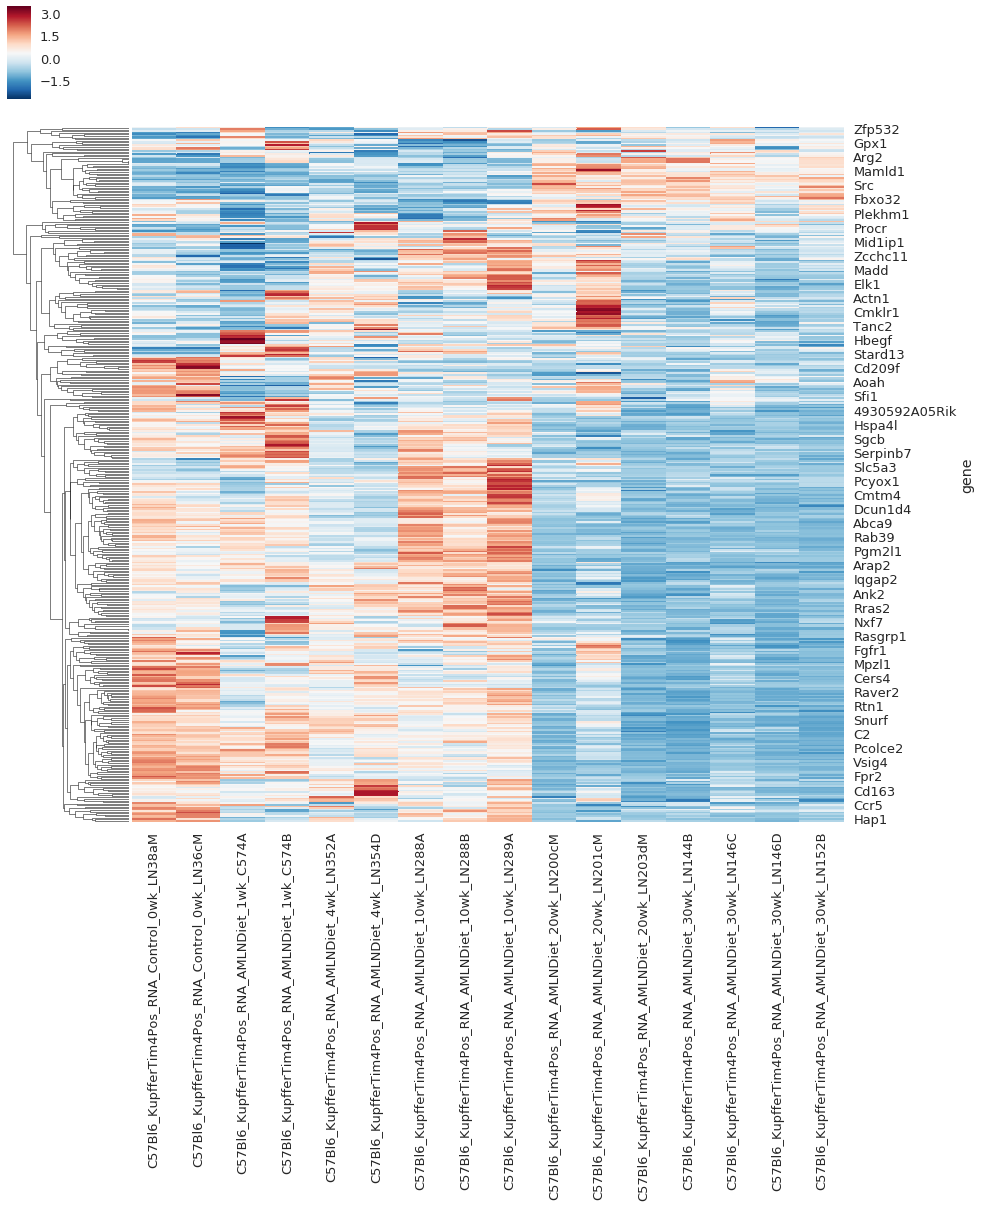

In [46]:
sns.clustermap(tpm_mat_filt.loc[lxrko_down, :].dropna(),
               z_score=0, cmap='RdBu_r', col_cluster=False, figsize=(15,15))

/home/h1bennet/anaconda3/envs/deseq/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  """Entry point for launching an IPython kernel.
/home/h1bennet/anaconda3/envs/deseq/lib/python3.6/site-packages/pandas/core/indexing.py:1367: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


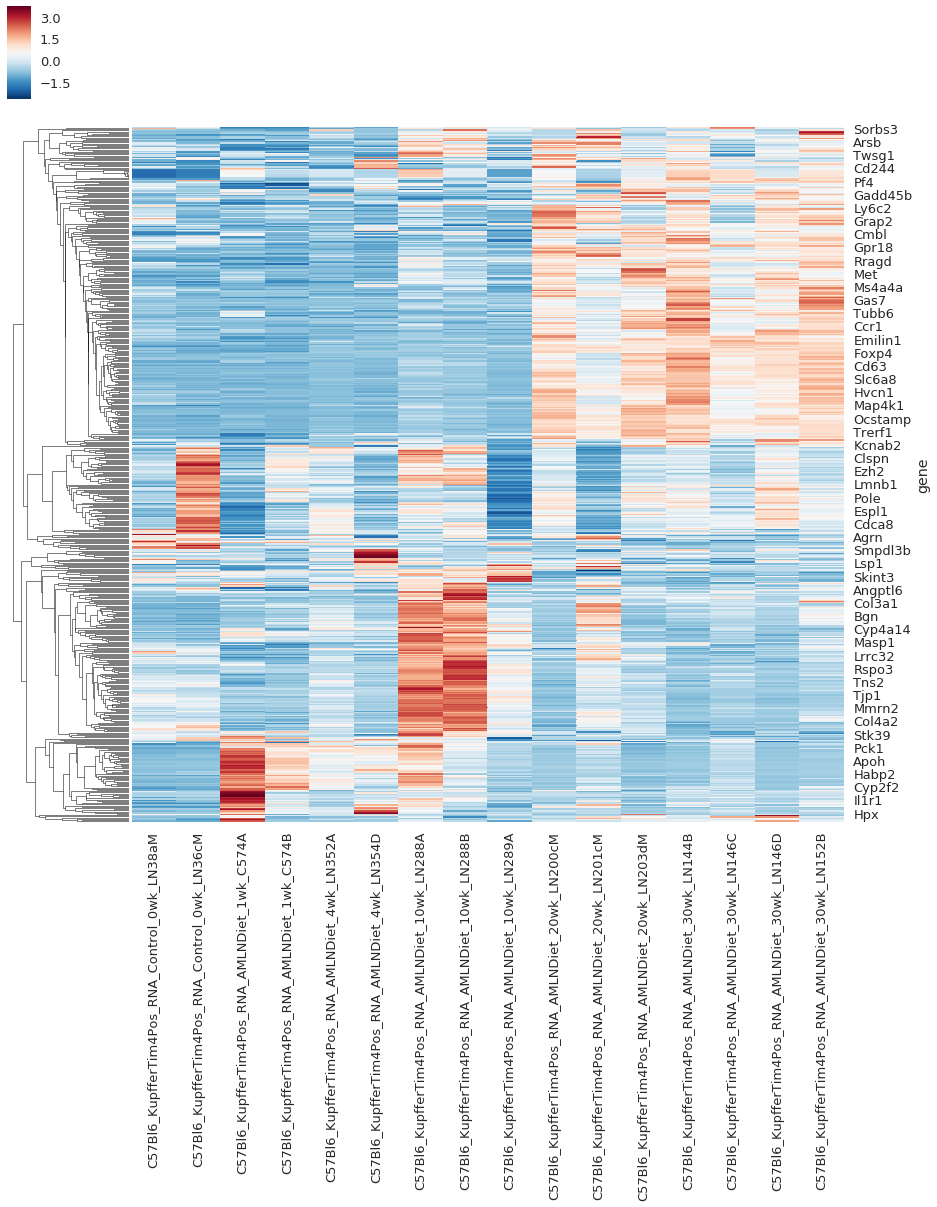

In [414]:
sns.clustermap(tpm_mat_filt.loc[lxrko_up, :].dropna(),
               z_score=0, cmap='RdBu_r', col_cluster=False, figsize=(15,15))

Compare to interesting LXR Pathway GO terms

In [38]:
pos_reg_lipid_trans = hbUtils.pull_go_terms("GO:0032370", taxon_id='10090', product_type='protein')
pos_reg_lipid_trans = [entry[1] for entry in pos_reg_lipid_trans]
pos_reg_chol_eff = hbUtils.pull_go_terms("GO:0010875", taxon_id='10090', product_type='protein')
pos_reg_chol_eff = [entry[1] for entry in pos_reg_chol_eff]
# lipid_biosyn_proc = hbUtils.pull_go_terms("GO:0008610", taxon_id='10090', product_type='protein')
# lipid_biosyn_proc = [entry[1] for entry in lipid_biosyn_proc]
trigly_met_proc = hbUtils.pull_go_terms("GO:0006641", taxon_id='10090', product_type='protein')
trigly_met_proc = [entry[1] for entry in trigly_met_proc]
lxr = list(set(pos_reg_lipid_trans + pos_reg_chol_eff + trigly_met_proc))

In [47]:
tpm_mat_filt.loc['Dhcr7', :]

C57Bl6_KupfferTim4Pos_RNA_Control_0wk_LN38aM       29.999346
C57Bl6_KupfferTim4Pos_RNA_Control_0wk_LN36cM       31.475021
C57Bl6_KupfferTim4Pos_RNA_AMLNDiet_1wk_C574A       27.700746
C57Bl6_KupfferTim4Pos_RNA_AMLNDiet_1wk_C574B       28.694978
C57Bl6_KupfferTim4Pos_RNA_AMLNDiet_4wk_LN352A      28.743935
C57Bl6_KupfferTim4Pos_RNA_AMLNDiet_4wk_LN354D      33.664310
C57Bl6_KupfferTim4Pos_RNA_AMLNDiet_10wk_LN288A     29.967220
C57Bl6_KupfferTim4Pos_RNA_AMLNDiet_10wk_LN288B     32.514719
C57Bl6_KupfferTim4Pos_RNA_AMLNDiet_10wk_LN289A     22.462617
C57Bl6_KupfferTim4Pos_RNA_AMLNDiet_20wk_LN200cM    63.628034
C57Bl6_KupfferTim4Pos_RNA_AMLNDiet_20wk_LN201cM    65.938287
C57Bl6_KupfferTim4Pos_RNA_AMLNDiet_20wk_LN203dM    70.593867
C57Bl6_KupfferTim4Pos_RNA_AMLNDiet_30wk_LN144B     51.524819
C57Bl6_KupfferTim4Pos_RNA_AMLNDiet_30wk_LN146C     51.831800
C57Bl6_KupfferTim4Pos_RNA_AMLNDiet_30wk_LN146D     54.900802
C57Bl6_KupfferTim4Pos_RNA_AMLNDiet_30wk_LN152B     51.616134
Name: Dhcr7, dtype: floa

/home/h1bennet/anaconda3/envs/deseq/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  """Entry point for launching an IPython kernel.
/home/h1bennet/anaconda3/envs/deseq/lib/python3.6/site-packages/pandas/core/indexing.py:1367: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


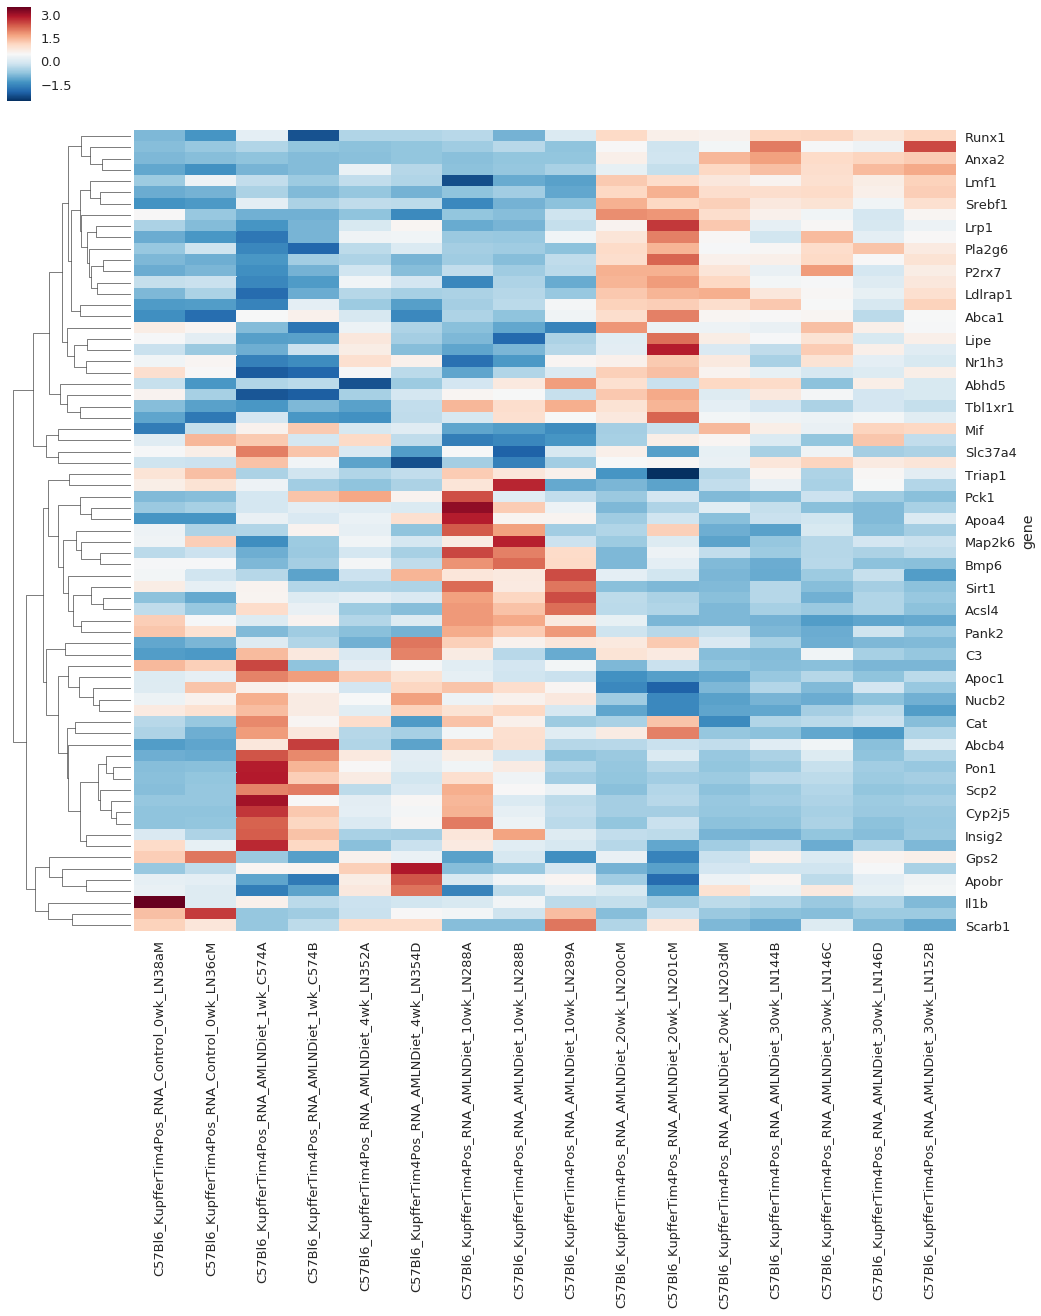

In [39]:
sns.clustermap(tpm_mat_filt.loc[lxr, :].dropna(),
               z_score=0, cmap='RdBu_r', col_cluster=False, figsize=(17,17))

In [72]:
beta_ox = hbUtils.pull_go_terms("GO:0006635", taxon_id='10090', product_type='protein')
beta_ox = set([entry[1] for entry in beta_ox])

/home/h1bennet/anaconda3/envs/deseq/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  """Entry point for launching an IPython kernel.
/home/h1bennet/anaconda3/envs/deseq/lib/python3.6/site-packages/pandas/core/indexing.py:1367: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


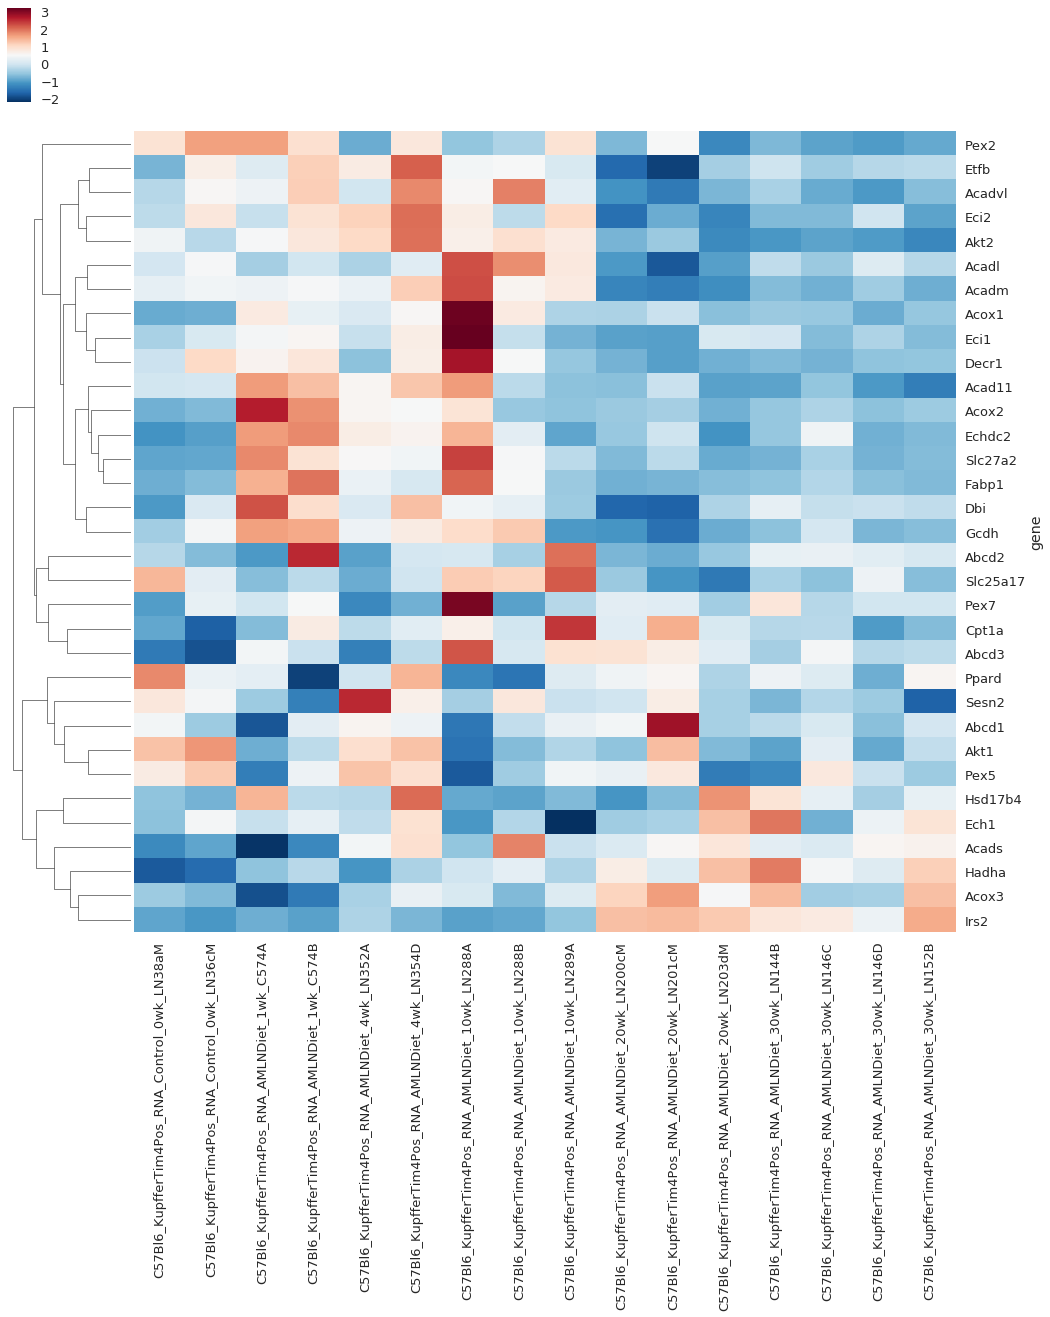

In [77]:
sns.clustermap(tpm_mat_filt.loc[beta_ox, :].dropna(),
               z_score=0, cmap='RdBu_r', col_cluster=False, figsize=(17,17))